# Integrate People with Air Theme 1
Spatial join air team data with people.

## Description of Program
- program:    ip1_2av1_joinpeopleair
- task:       Read Air files from CKAN - Join HUA with File
- Version:    2025-12-19
- project:    Southeast Texas Urban Integrated Field Lab
- funding:	  DOE
- author:     Nathanael Rosenheim

## Step 0: Good Housekeeping

In [1]:
# 1. Import all packages
import pandas as pd     # For obtaining and cleaning tabular data
import geopandas as gpd # For obtaining and cleaning spatial data
import matplotlib.pyplot as plt # For plotting
import contextily as ctx # For adding basemaps
import os # For saving output to path
import zipfile # For handling zip files
import io # For handling in-memory data
import requests # For downloading data
import rasterio # For reading geotiff files

In [2]:
# 2. Check versions
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)

Python Version      3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:12:41) [MSC v.1944 64 bit (AMD64)]
geopandas version:  1.1.1


In [3]:
# 3. Check working directory
# Get information on current working directory (getcwd)
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\GitHub\\integrate_people_theme1_cookbook'

In [4]:
#4. Store Program Name for output files to have the same name
programname = "ip1_2av1_joinpeopleair"
# Make directory to save output
#if not os.path.exists(programname):
#    os.mkdir(programname)

In [5]:
# Functions to explore the housing unit allocation results
# load functions from Github repository
ncoda_00d_cleanvarsutils_url = "https://github.com/npr99/intersect-community-data/raw/main/pyncoda/ncoda_00d_cleanvarsutils.py"
ncoda_04c_poptableresults_url = "https://github.com/npr99/intersect-community-data/raw/main/pyncoda/ncoda_04c_poptableresults.py"

import requests
import importlib.util

# Load the clean vars utils functions
response1 = requests.get(ncoda_00d_cleanvarsutils_url)
exec(response1.text)

# Load the pop table results functions - skip first 5 lines
response2 = requests.get(ncoda_04c_poptableresults_url)
# Split into lines, skip first 5, then rejoin
lines = response2.text.split('\n')
code_to_exec = '\n'.join(lines[5:])
exec(code_to_exec)

print("Successfully loaded functions from both GitHub repositories")

Successfully loaded functions from both GitHub repositories


# Step 1: Obtain Data
Obtain publicly available data on CKAN

https://ckan.tacc.utexas.edu/organization/setx-uifl

- Housing unit level population data allocated to structures
- Study site boundaries
- Social Vulnerability Data
- Air pollution

In [6]:
# housing unit allocation data from CKAN
data_title = "2020 Housing Unit Allocation for SETX"
url = "https://ckan.tacc.utexas.edu/dataset/62308724-7eac-45ed-aeab-d4d6a46128e1/resource/5154eb5e-d8ff-4183-b361-fd530513e3c1/download/hua_v2-0-0_setxuifl_tx_nsi_2020_nsi_rs9876.csv"

# read in blockid, bgid, tractid, FIPSCounty as strings
dtypes_dict = {
    'blockid': str,
    'bgid': str,
    'tractid': str,
    'FIPSCounty': str
}
hua_df = pd.read_csv(url, dtype=dtypes_dict)
hua_df.head(1)

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2020_flagsetrm,addrptid,fd_id_bid,huestimate,huicounter_addpt,placeNAME20,x,y,occtype,geometry
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,2.0,ST00nsi-481325235-86274HQQ+WH4-8-3-8-4AP000000,nsi-481325235-86274HQQ+WH4-8-3-8-4,0.0,1.0,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.411062 30.139761)


In [7]:
# task force sites
data_title = "Task Force Top Two Focus Sites"
url = "https://ckan.tacc.utexas.edu/dataset/cfe91d1b-3aa9-4de1-ba76-2837deb87649/resource/7e2e3d0e-60cc-4fb1-beea-d30a62cdd1e9/download/task_force_sites_top_focus_may_2024.zip"

tfsites_gdf = gpd.read_file(url)
tfsites_gdf.head()

,Shape_Leng,Shape_Area,Site_Name,geometry
0,0.0,0.0,West Port Arthur - Foley Watershed,"POLYGON Z ((-10458830.588 3488032.728 0, -1045..."
1,0.0,0.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...,"POLYGON Z ((-10476419.371 3513315.472 0, -1047..."


In [8]:
# Add SVI data by tract and block group
data_title = "2020 SVI Data for SETX Block Groups"
blockgroup_svi_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/8c77ff75-e8dc-436c-af09-d353b7adea0c/download/tu3svi4_2av2_svioptions_2025-04-16_bg2020_setx.zip'
blockgroup_svi_gdf = gpd.read_file(blockgroup_svi_url)
blockgroup_svi_gdf.head(1)

,BG2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,TRACT2020,airsite_bg,airsite_na,geometry
0,482450108004,1805083,0,0.11097,0.33012,0.0,-24429.0,-0.03282,-185900.0,1033.0,...,0.323,1.0,1.0,1.0,1.0,48245,48245010800,0.0,None,"POLYGON ((-93.96848 29.98396, -93.96712 29.985..."


In [9]:
data_title = "2020 SVI Data for SETX Tracts"
tract_svi_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/112f6e55-f843-46bc-bd2f-952753efbab2/download/tu3svi4_2av2_svioptions_2025-04-16_tract2020_setx.zip'
tract_svi_gdf = gpd.read_file(tract_svi_url)
tract_svi_gdf.head(1)

,TRACT2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,airsite_tr,airsite_na,area_m^2,geometry
0,48351950100,779155722,9905672,0.31786,0.43767,0.13483,-23537.0,-0.00928,-77100.0,827.0,...,0.594,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.91113 31.15807, -93.90629 31.158..."


In [10]:
data_title = "2020 SVI Data Dictionary"
svi_datadictionary_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/c25d8010-a142-4ee8-8eea-fe7fa3ca4b4d/download/tu3svi4_2av2_svioptions_2025-04-16_all_vars_datadictionary.csv.xlsx'
# read in xlsx file
svi_datadictionary_df = pd.read_excel(svi_datadictionary_url)
svi_datadictionary_df.head(1)


,SVI,year,newvarname,SVIcat,label,oldvarname
0,CDC,2020,C202010010,Geocode,Census Tract 11 Digit Geocode,FIPS


In [11]:
# Add Air Pollution Data
air_pollution_url = "https://ckan.tacc.utexas.edu/dataset/c3c1b2b2-4d43-4603-b1c5-fc0877c279ae/resource/465209c8-f407-4eb2-99b3-4fc719e168c3/download/simulated_percentile_conc.zip"

# Dictionary to store the geotiff data organized by subfolders
air_pollution_dict = {}

# Mapping for species codes to full names
species_mapping = {
    'antl': 'Acetonitrile',
    'be13': '1,3-Butadiene',
    'benz': 'Benzene',
    'etbz': 'Ethylbenzene',
    'etox': 'Ethylene Oxide',
    'nhex': 'Hexane',
    'strn': 'Styrene',
    'tolu': 'Toluene',
    'xyln': 'Xylenes'
}

# Function to create descriptive key from filename
def create_descriptive_key(filename):
    """
    Parse filename structure and create descriptive key
    Filename structure: v720ut3_uifl_4km_1km_rtracv3_*_{gridname}_{species}_ppb_apr_oct_{statistics}.tif
        - gridname is grd01 or grd02 specifying the modeling domain, uifl_4km or uifl_1km, respectively
        - species can be antl (Acetonitrile), be13 (1,3-Butadiene), benz (Benzene), etbz (Ethylbenzene), etox (Ethylene Oxide), nhex (Hexane), strn (Styrene), tolu (Toluene) or xyln (mixed isomers of Xylenes).
        - statistics has the format of pXX where XX is percentile, e.g. p50 represents the 50th percentile, or the word "mean" for mean.
    example: 
        - Filename = v720ut3_uifl_4km_1km_rtracv3_bzhx_grd02_benz_ppb_apr_oct_p75
            - key = Benzene 75th percentile 1km
    """
    parts = filename.split('_')
    
    # Extract components from filename parts
    gridname = None
    species = None
    statistics = None
    
    for i, part in enumerate(parts):
        # Find gridname (grd01 or grd02)
        if part in ['grd01', 'grd02']:
            gridname = part
        # Find species code (should be after gridname)
        elif gridname and part in species_mapping:
            species = part
        # Find statistics (last meaningful part before extension)
        elif part.startswith('p') and part[1:].isdigit():
            statistics = part
        elif part == 'mean':
            statistics = part
    
    # Format statistics for key
    if statistics and statistics.startswith('p'):
        stat_display = f"p{statistics[1:]}"  # Keep percentile format shorter
    elif statistics == 'mean':
        stat_display = 'mean'
    else:
        stat_display = statistics if statistics else 'unknown'
    
    # Create descriptive key (shorter format)
    descriptive_key = stat_display
    
    return descriptive_key

# Download and read TIFF files from the zip
response = requests.get(air_pollution_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Get list of all files in the zip
    file_list = z.namelist()
    
    # Filter for .tif files
    tif_files = [f for f in file_list if f.endswith('.tif') or f.endswith('.tiff')]
    
    print(f"Found {len(tif_files)} TIFF files in total")
    
    # Process each TIFF file and organize by subfolder structure
    for tif_file in tif_files:
        # Parse the file path
        path_parts = tif_file.split('/')
        
        if len(path_parts) >= 3:  # resolution/species/filename
            resolution_dir = path_parts[0]  # e.g., 'uifl_1km' or 'uifl_4km'
            species_dir = path_parts[1]     # e.g., 'benz', 'tolu', etc.
            filename = os.path.splitext(path_parts[2])[0]  # filename without extension
            
            # Create nested dictionary structure: resolution -> species -> statistic
            if resolution_dir not in air_pollution_dict:
                air_pollution_dict[resolution_dir] = {}
            
            # Get species full name
            species_name = species_mapping.get(species_dir, species_dir)
            
            if species_name not in air_pollution_dict[resolution_dir]:
                air_pollution_dict[resolution_dir][species_name] = {}
            
            # Create descriptive key for the statistic
            statistic_key = create_descriptive_key(filename)
            
            # Read the TIFF file data
            with z.open(tif_file) as file_data:
                # Use rasterio to read the geotiff
                with rasterio.open(file_data) as src:
                    # Store the rasterio dataset in the nested dictionary
                    air_pollution_dict[resolution_dir][species_name][statistic_key] = {
                        'data': src.read(),  # Read all bands
                        'transform': src.transform,
                        'crs': src.crs,
                        'meta': src.meta,
                        'bounds': src.bounds,
                        'width': src.width,
                        'height': src.height,
                        'original_filename': filename,  # Keep original filename for reference
                        'file_path': tif_file  # Keep original file path
                    }

print(f"\nSuccessfully organized {len(tif_files)} geotiff files into nested dictionary")
print(f"Resolution levels: {list(air_pollution_dict.keys())}")

# Display the structure
for resolution in air_pollution_dict.keys():
    species_count = len(air_pollution_dict[resolution])
    print(f"\n{resolution}: {species_count} species")
    for species in air_pollution_dict[resolution].keys():
        stat_count = len(air_pollution_dict[resolution][species])
        stats = list(air_pollution_dict[resolution][species].keys())
        print(f"  {species}: {stat_count} statistics ({', '.join(sorted(stats))})")

Found 162 TIFF files in total

Successfully organized 162 geotiff files into nested dictionary
Resolution levels: ['uifl_1km', 'uifl_4km']

uifl_1km: 9 species
  Benzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Acetonitrile: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  1,3-Butadiene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Styrene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Ethylene Oxide: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Toluene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Hexane: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Ethylbenzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Xylenes: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)

uifl_4km: 9 species
  Benzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Acetonitrile: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)


In [20]:
# check one of the geotiff files
sample_key = list(air_pollution_dict['uifl_1km']['Benzene']['p90'].keys())
sample_data = air_pollution_dict['uifl_1km']['Benzene']['p90']['data']

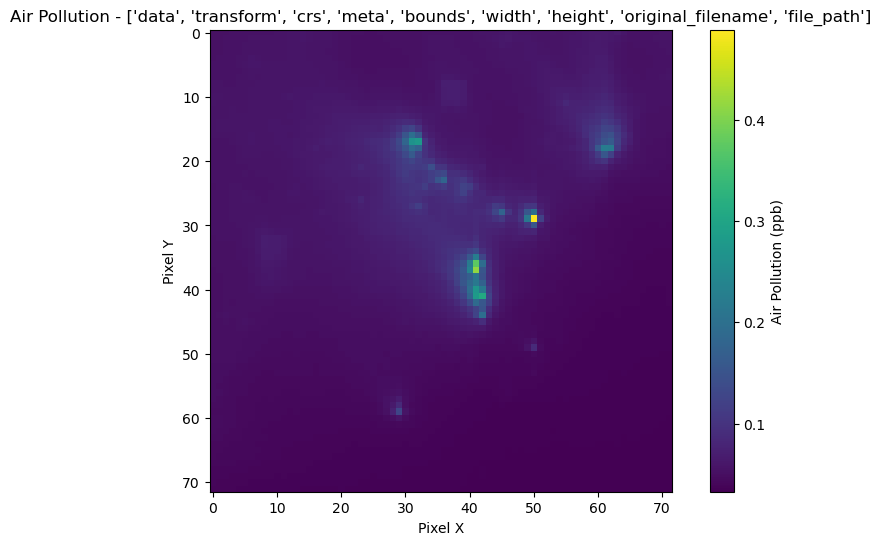

In [21]:
# Visualize the sample data
plt.figure(figsize=(10, 6))
plt.imshow(sample_data[0], cmap='viridis')
plt.colorbar(label='Air Pollution (ppb)')
plt.title(f"Air Pollution - {sample_key}")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

# Step 2: Clean Data

In [22]:
# convert hua_df to a GeoDataFrame
# use geometry column
hua_gdf = gpd.GeoDataFrame(hua_df, geometry=gpd.GeoSeries.from_wkt(hua_df['geometry']), crs="EPSG:4326")
hua_gdf.head()

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2020_flagsetrm,addrptid,fd_id_bid,huestimate,huicounter_addpt,placeNAME20,x,y,occtype,geometry
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,2.0,ST00nsi-481325235-86274HQQ+WH4-8-3-8-4AP000000,nsi-481325235-86274HQQ+WH4-8-3-8-4,0.0,1.0,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.41106 30.13976)
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,2.0,ST00nsi-481325996-86274HQQ+XP2-3-2-3-1AP000000,nsi-481325996-86274HQQ+XP2-3-2-3-1,0.0,1.0,Sour Lake,-94.410730,30.139890,COM4,POINT (-94.41073 30.13989)
2,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nsi-481326655-86274HQQ+JQ2-3-2-4-2,NaN,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.4106 30.139)
3,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nsi-481326679-86274HQQ+JPC-3-2-3-2,NaN,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.41073 30.13906)
4,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nsi-481326680-86274HRV+25G-4-3-1-2,NaN,NaN,NaN,NaN,NaN,COM4,POINT (-94.40704 30.14007)


<Axes: >

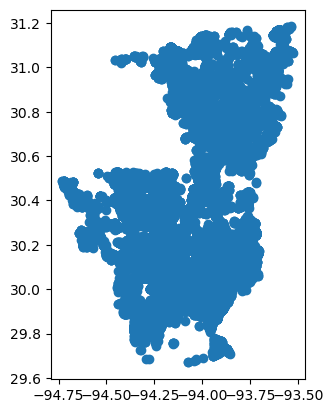

In [23]:
hua_gdf.plot()

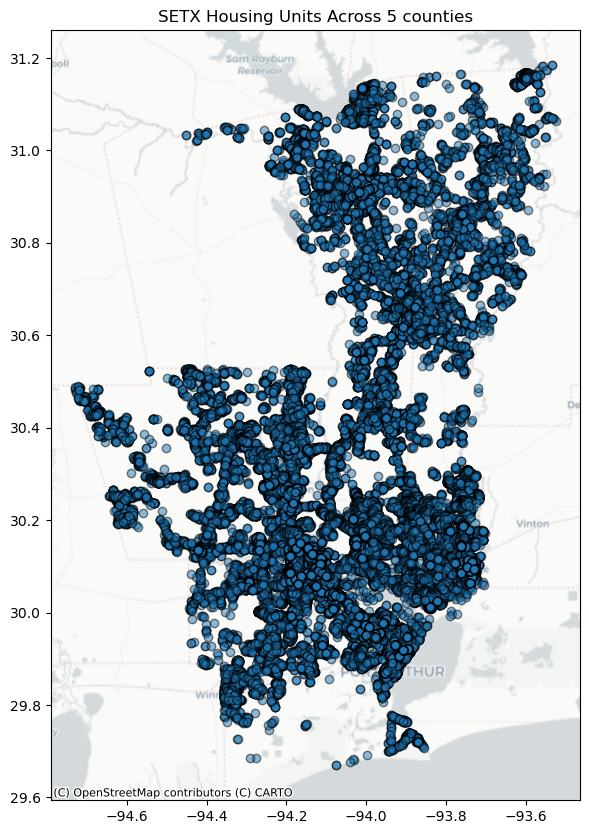

In [24]:
# make a map of points with basemap
ax = hua_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=hua_gdf.crs, source=ctx.providers.CartoDB.Positron)
# add title 
ax.set_title("SETX Housing Units Across 5 counties")
plt.show()


<Axes: >

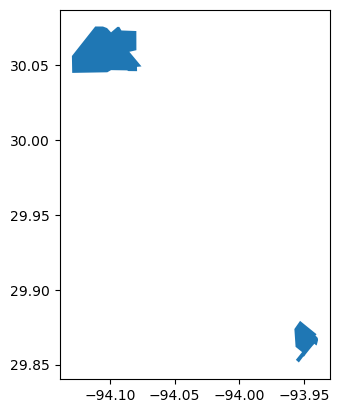

In [25]:
# convert task force site CRS to match hua_gdf
tfsites_gdf = tfsites_gdf.to_crs(hua_gdf.crs)
tfsites_gdf.plot()

In [26]:
# add site id to task force gdf
tfsites_gdf['Site_ID'] = tfsites_gdf.index + 1
tfsites_gdf = tfsites_gdf[['Site_ID','Site_Name', 'geometry']]
tfsites_gdf.head()

,Site_ID,Site_Name,geometry
0,1,West Port Arthur - Foley Watershed,"POLYGON Z ((-93.95327 29.87921 0, -93.94959 29..."
1,2,Southeast Beaumont - Hillebrant Bayou/Tenmile ...,"POLYGON Z ((-94.11128 30.07594 0, -94.10533 30..."


### Spatial Join
Add Task Force Site ID to HUA

In [27]:
# spatial join hua_gdf with tfsites_gdf
hua_tfsites_gdf = gpd.sjoin(hua_gdf, tfsites_gdf, how="left", predicate="intersects")
hua_tfsites_gdf.head()

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,huestimate,huicounter_addpt,placeNAME20,x,y,occtype,geometry,index_right,Site_ID,Site_Name
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.0,1.0,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.41106 30.13976),NaN,NaN,NaN
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.0,1.0,Sour Lake,-94.410730,30.139890,COM4,POINT (-94.41073 30.13989),NaN,NaN,NaN
2,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.4106 30.139),NaN,NaN,NaN
3,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.41073 30.13906),NaN,NaN,NaN
4,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,COM4,POINT (-94.40704 30.14007),NaN,NaN,NaN


In [28]:
#  select census tracts that intersect with task force sites
hua_tfsites_gdf_tracts = hua_tfsites_gdf[~hua_tfsites_gdf['Site_ID'].isna()]
# summarize number of tracts intersecting with each site
hua_tfsites_gdf_tracts.groupby(['Site_ID','tractid']).size()


Site_ID  tractid    
1.0      48245005100     427
         48245005900     582
2.0      48245001200      73
         48245001700     748
         48245001900    1034
         48245002000     873
         48245002100    1034
         48245002200     583
         48245002300     913
         48245002400    1083
         48245002500     291
         48245002600     581
         48245011700     158
dtype: int64

In [29]:
# how many unique tracts intersect with task force sites
# count by Site_ID
hua_tfsites_gdf_tracts.groupby('Site_ID')['tractid'].nunique()

Site_ID
1.0     2
2.0    11
Name: tractid, dtype: int64

In [30]:
#  select census tracts that intersect with task force sites
hua_tfsites_gdf_bg = hua_tfsites_gdf[~hua_tfsites_gdf['Site_ID'].isna()]
# summarize number of tracts intersecting with each site
hua_tfsites_gdf_bg.groupby(['Site_ID','bgid']).size()

Site_ID  bgid        
1.0      482450051001    213
         482450051002    214
         482450059001    406
         482450059002    176
2.0      482450012002     73
         482450017001    271
         482450017002    243
         482450017003    234
         482450019001    340
         482450019002    245
         482450019003    449
         482450020001    316
         482450020002    557
         482450021001    123
         482450021002    569
         482450021003    342
         482450022001    213
         482450022002    131
         482450022003    239
         482450023001    322
         482450023002    309
         482450023003    202
         482450023004     80
         482450024001    256
         482450024002    268
         482450024003    268
         482450024004    291
         482450025001    291
         482450026002     45
         482450026004    536
         482450117002    158
dtype: int64

In [31]:
# how many unique tracts intersect with task force sites
# count by Site_ID
hua_tfsites_gdf_bg.groupby('Site_ID')['bgid'].nunique()

Site_ID
1.0     4
2.0    27
Name: bgid, dtype: int64

In [32]:
tract_svi_gdf.head()

,TRACT2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,airsite_tr,airsite_na,area_m^2,geometry
0,48351950100,779155722,9905672,0.31786,0.43767,0.13483,-23537.0,-0.00928,-77100.0,827.0,...,0.594,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.91113 31.15807, -93.90629 31.158..."
1,48351950300,485357049,2214858,0.30314,0.51767,0.09422,-20002.0,-0.00000,-67800.0,632.0,...,0.542,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.88919 30.43845, -93.88899 30.441..."
2,48351950400,296202703,605235,0.19510,0.37127,0.06878,-26501.0,-0.04757,-101900.0,821.0,...,0.519,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.90145 30.25293, -93.90145 30.252..."
3,48241950701,344503029,3181130,0.03623,0.37354,0.10871,-35488.0,-0.04386,-113200.0,584.0,...,0.382,2.0,2.0,1.0,1.0,48241,0.0,None,NaN,"POLYGON ((-94.12066 30.28106, -94.12042 30.281..."
4,48241950102,444058152,6807777,0.11693,0.43997,0.06844,-39065.0,-0.08815,-93800.0,1087.0,...,0.450,2.0,2.0,1.0,1.0,48241,0.0,None,NaN,"POLYGON ((-94.46017 31.03122, -94.45981 31.031..."


In [33]:
# make list of unique tracts in site list with sitename
# get unique tract/site combinations
tract_site_df = hua_tfsites_gdf_tracts[['tractid','Site_ID','Site_Name']].drop_duplicates()
# drop Nan Tractids
tract_site_df = tract_site_df.dropna()
tract_site_df

,tractid,Site_ID,Site_Name
36122,48245005900,1.0,West Port Arthur - Foley Watershed
37720,48245002200,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,48245002400,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,48245002100,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,48245011700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45437,48245001900,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
68991,48245005100,1.0,West Port Arthur - Foley Watershed
88417,48245002600,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
88915,48245001700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
89712,48245002500,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


In [34]:
# make list of unique bg in site list with sitename
# get unique bg/site combinations
bg_site_df = hua_tfsites_gdf_tracts[['bgid','Site_ID','Site_Name']].drop_duplicates()
# drop Nan Tractids
bg_site_df = bg_site_df.dropna()
bg_site_df

,bgid,Site_ID,Site_Name
36122,482450059001,1.0,West Port Arthur - Foley Watershed
37720,482450022002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,482450024003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,482450021003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,482450117002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45437,482450019003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
49845,482450021001,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50060,482450022003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50810,482450024002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50903,482450022001,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


In [35]:
tract_site_df.head()

,tractid,Site_ID,Site_Name
36122,48245005900,1.0,West Port Arthur - Foley Watershed
37720,48245002200,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,48245002400,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,48245002100,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,48245011700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


<Axes: >

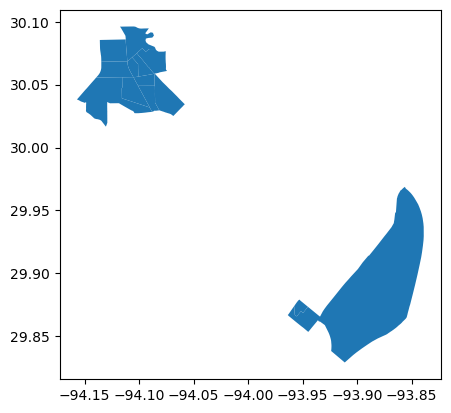

In [36]:
# merge tract_site_df with tract_svi_gdf
tract_site_gdf = tract_svi_gdf.merge(tract_site_df, left_on='TRACT2020', right_on='tractid')
# keep if site id is not null
tract_site_gdf = tract_site_gdf[~tract_site_gdf['Site_ID'].isna()]
tract_site_gdf.plot()

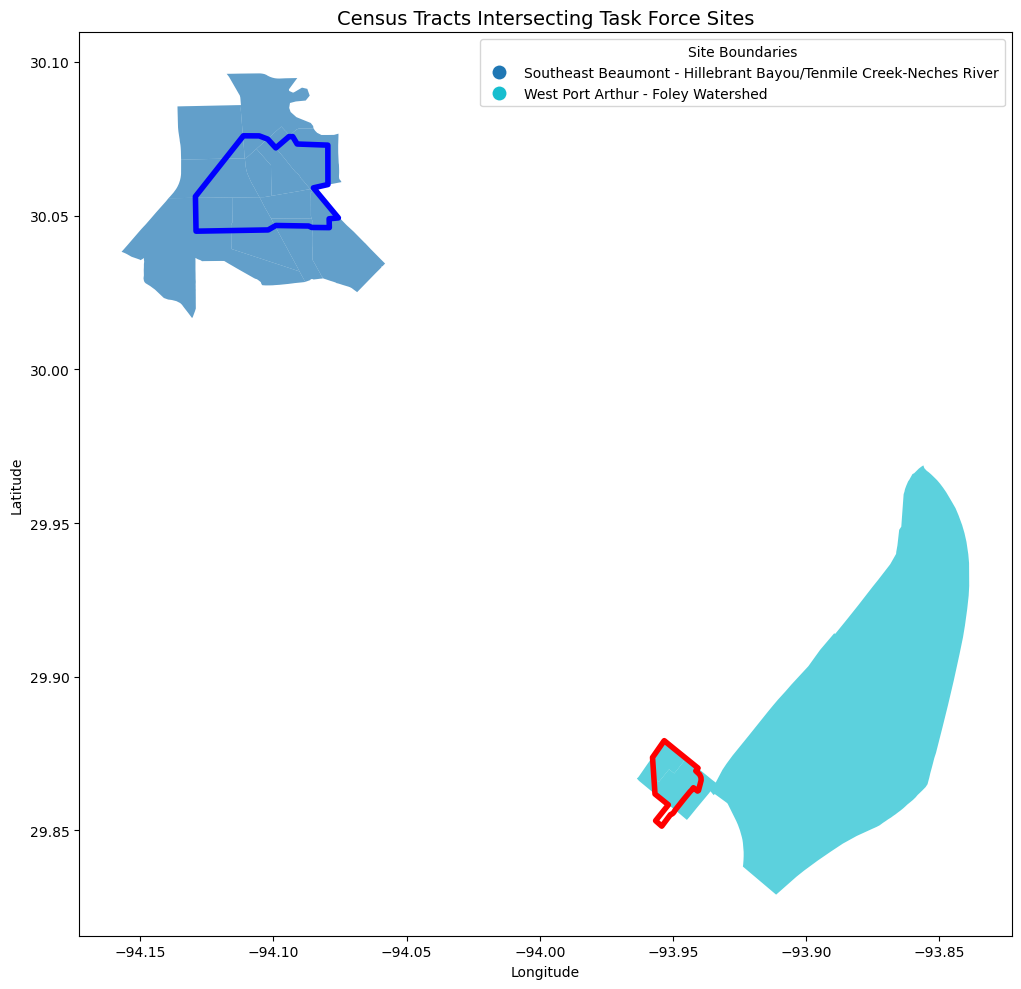

In [37]:
# make a map that shows the task force sites and the intersecting census tracts
fig, ax = plt.subplots(figsize=(12, 10))

# Plot census tracts colored by Site_Name
tract_site_gdf.plot(column='Site_Name', legend=True, ax=ax, alpha=0.7, 
                   legend_kwds={'title': 'Task Force Sites'})

# Plot task force sites as colored outlines based on Site_Name
tfsites_gdf.plot(ax=ax, facecolor='none', column='Site_Name', 
                edgecolor=['red', 'blue'], linewidth=4, legend=True,
                legend_kwds={'title': 'Site Boundaries', 'loc': 'upper right'})

plt.title("Census Tracts Intersecting Task Force Sites", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [32]:
# spatial join air_pollution_dict with hua_tfsites_gdf
# Extract air pollution values at each housing unit location

# Import additional libraries needed for raster sampling
from rasterio.features import geometry_mask
from rasterio.warp import transform_geom
import numpy as np
from shapely.geometry import Point

# Create a copy of the housing unit data to add air pollution values
hua_air_gdf = hua_tfsites_gdf.copy()

# Test with just the first air pollution raster
first_pollutant = list(air_pollution_dict.keys())[0]
print(f"Testing with: {first_pollutant}")

# Get the first raster data
raster_data = air_pollution_dict[first_pollutant]

print(f"Processing {first_pollutant}...")

# Get raster properties
raster_crs = raster_data['crs']
transform = raster_data['transform']
data = raster_data['data'][0]  # Get the first band

# Transform housing unit coordinates to match raster CRS
hua_transformed = hua_air_gdf.to_crs(raster_crs)

# Extract coordinates
coords = [(geom.x, geom.y) for geom in hua_transformed.geometry]

# Sample raster values at point locations
from rasterio import sample

# Create a temporary in-memory raster for sampling
with rasterio.MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype=data.dtype,
        crs=raster_crs,
        transform=transform,
    ) as dataset:
        dataset.write(data, 1)
        
        # Sample values at point locations
        sampled_values = [val[0] for val in dataset.sample(coords)]

# Add the air pollution values as a new column
hua_air_gdf[f'{first_pollutant}_ppb'] = sampled_values

print(f"Added {first_pollutant}_ppb column - Min: {np.nanmin(sampled_values):.3f}, Max: {np.nanmax(sampled_values):.3f}")
print(f"Number of valid values: {np.sum(~np.isnan(sampled_values))}")
print(f"Number of NaN values: {np.sum(np.isnan(sampled_values))}")

print(f"\nCompleted spatial join for {first_pollutant}.")
print(f"New column: {first_pollutant}_ppb")

# Display summary
hua_air_gdf.head()

Testing with: benz_ppb_p100
Processing benz_ppb_p100...
Added benz_ppb_p100_ppb column - Min: 0.000, Max: 1.121
Number of valid values: 226925
Number of NaN values: 0

Completed spatial join for benz_ppb_p100.
New column: benz_ppb_p100_ppb
Added benz_ppb_p100_ppb column - Min: 0.000, Max: 1.121
Number of valid values: 226925
Number of NaN values: 0

Completed spatial join for benz_ppb_p100.
New column: benz_ppb_p100_ppb


,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,huicounter_addpt,placeNAME20,x,y,occtype,geometry,index_right,Site_ID,Site_Name,benz_ppb_p100_ppb
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,1.0,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.41106 30.13976),NaN,NaN,NaN,0.0
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,1.0,Sour Lake,-94.410730,30.139890,COM4,POINT (-94.41073 30.13989),NaN,NaN,NaN,0.0
2,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.4106 30.139),NaN,NaN,NaN,0.0
3,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RES1-1SNB,POINT (-94.41073 30.13906),NaN,NaN,NaN,0.0
4,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,COM4,POINT (-94.40704 30.14007),NaN,NaN,NaN,0.0


## Loop Through All Air Pollution Geotiffs for Spatial Join

Now that we have the updated air_pollution_dict structure with nested organization (resolution -> species -> statistic), let's perform spatial joins across all possible geotiffs.

In [38]:
# Complete spatial join for ALL air pollution geotiffs with housing units
# This will loop through all resolutions, species, and statistics

# Import additional libraries needed for raster sampling
from rasterio.features import geometry_mask
from rasterio.warp import transform_geom
import numpy as np
from shapely.geometry import Point
from rasterio import sample
import time

# Create a copy of the housing unit data to add air pollution values
hua_air_complete_gdf = hua_tfsites_gdf.copy()

# Track progress
total_rasters = 0
successful_joins = 0
failed_joins = 0

# Count total number of rasters to process
print("Counting available geotiffs...")
for resolution in air_pollution_dict:
    for species in air_pollution_dict[resolution]:
        for statistic in air_pollution_dict[resolution][species]:
            total_rasters += 1

print(f"Found {total_rasters} geotiff files to process")
print("Starting spatial join process...\n")

start_time = time.time()

# Loop through all resolutions
for resolution in air_pollution_dict:
    print(f"Processing resolution: {resolution}")
    
    # Loop through all species for this resolution
    for species in air_pollution_dict[resolution]:
        print(f"  Processing species: {species}")
        
        # Loop through all statistics for this species
        for statistic in air_pollution_dict[resolution][species]:
            try:
                # Get raster data
                raster_data = air_pollution_dict[resolution][species][statistic]
                
                # Create column name (ensure it's unique and descriptive)
                resolution_short = resolution.replace('uifl_', '')  # Remove prefix for cleaner names
                column_name = f"{species}_{statistic}_{resolution_short}"
                
                print(f"    Processing {statistic} -> Column: {column_name}")
                
                # Get raster properties
                raster_crs = raster_data['crs']
                transform = raster_data['transform']
                data = raster_data['data'][0]  # Get the first band
                
                # Transform housing unit coordinates to match raster CRS
                hua_transformed = hua_air_complete_gdf.to_crs(raster_crs)
                
                # Extract coordinates
                coords = [(geom.x, geom.y) for geom in hua_transformed.geometry]
                
                # Sample raster values at point locations using in-memory dataset
                with rasterio.MemoryFile() as memfile:
                    with memfile.open(
                        driver='GTiff',
                        height=data.shape[0],
                        width=data.shape[1],
                        count=1,
                        dtype=data.dtype,
                        crs=raster_crs,
                        transform=transform,
                    ) as dataset:
                        dataset.write(data, 1)
                        
                        # Sample values at point locations
                        sampled_values = [val[0] for val in dataset.sample(coords)]
                
                # Add the air pollution values as a new column
                hua_air_complete_gdf[column_name] = sampled_values
                
                # Track statistics
                valid_values = np.array([v for v in sampled_values if not np.isnan(v)])
                successful_joins += 1
                
                print(f"      ✓ Added column - Valid values: {len(valid_values)}, "
                      f"Range: {np.min(valid_values):.3f}-{np.max(valid_values):.3f}")
                
            except Exception as e:
                failed_joins += 1
                print(f"      ✗ Failed to process {statistic}: {e}")

# Calculate processing time
end_time = time.time()
processing_time = end_time - start_time

print(f"\n" + "="*60)
print("SPATIAL JOIN COMPLETE")
print("="*60)
print(f"Total rasters processed: {total_rasters}")
print(f"Successful joins: {successful_joins}")
print(f"Failed joins: {failed_joins}")
print(f"Processing time: {processing_time:.2f} seconds")
print(f"Final dataset shape: {hua_air_complete_gdf.shape}")

# Show the new columns added
new_columns = [col for col in hua_air_complete_gdf.columns if '_ppb' not in col and any(species.replace(' ', '').replace('-', '').replace(',', '').lower() in col.lower() for species in ['Acetonitrile', 'Butadiene', 'Benzene', 'Ethylbenzene', 'Ethylene', 'Hexane', 'Styrene', 'Toluene', 'Xylenes'])]
air_pollution_columns = [col for col in hua_air_complete_gdf.columns if col not in hua_tfsites_gdf.columns]

print(f"\nAdded {len(air_pollution_columns)} air pollution columns:")
for i, col in enumerate(air_pollution_columns, 1):
    print(f"  {i}. {col}")

print(f"\nDataset now contains {len(hua_air_complete_gdf.columns)} total columns")

# Display first few rows to verify
print("\nFirst 3 rows of the expanded dataset:")
hua_air_complete_gdf.head(3)

Counting available geotiffs...
Found 162 geotiff files to process
Starting spatial join process...

Processing resolution: uifl_1km
  Processing species: Benzene
    Processing p75 -> Column: Benzene_p75_1km
      ✓ Added column - Valid values: 226925, Range: 0.000-0.290
    Processing p100 -> Column: Benzene_p100_1km
      ✓ Added column - Valid values: 226925, Range: 0.000-20.884
    Processing p95 -> Column: Benzene_p95_1km
      ✓ Added column - Valid values: 226925, Range: 0.000-0.651
    Processing p50 -> Column: Benzene_p50_1km
      ✓ Added column - Valid values: 226925, Range: 0.000-0.181
    Processing p25 -> Column: Benzene_p25_1km
      ✓ Added column - Valid values: 226925, Range: 0.000-0.126
    Processing p98 -> Column: Benzene_p98_1km
      ✓ Added column - Valid values: 226925, Range: 0.000-0.821
    Processing p90 -> Column: Benzene_p90_1km
      ✓ Added column - Valid values: 226925, Range: 0.000-0.489
    Processing mean -> Column: Benzene_mean_1km
      ✓ Added col

KeyboardInterrupt: 

In [39]:
hua_air_complete_gdf.head()

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,Styrene_mean_1km,Styrene_p95_1km,Styrene_p90_1km,Styrene_p99_1km,Styrene_p100_1km,Styrene_p98_1km,Styrene_p75_1km,Styrene_p25_1km,Ethylene Oxide_p98_1km,Ethylene Oxide_mean_1km
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Step 3: Explore Data

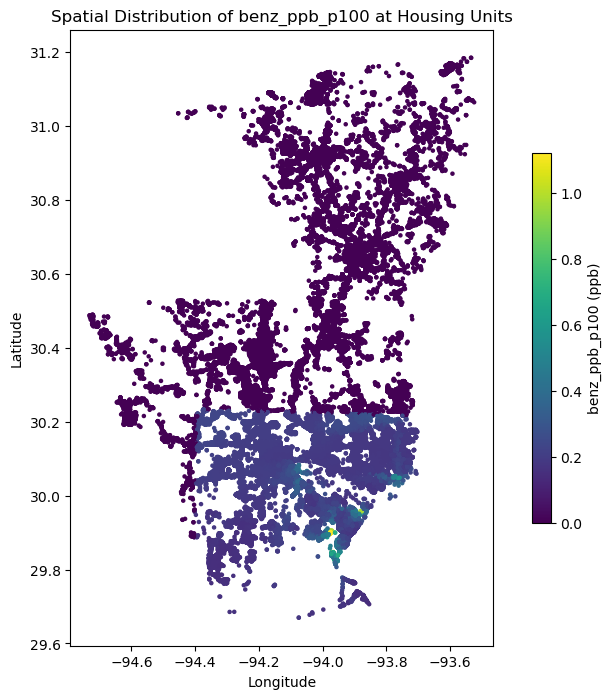

In [33]:
# map hua point data with air pollution values
fig, ax = plt.subplots(figsize=(10, 8))
hua_air_gdf.plot(column=f'{first_pollutant}_ppb', ax=ax, legend=True,
                 cmap='viridis', markersize=5,
                 legend_kwds={'label': f'{first_pollutant} (ppb)', 'shrink': 0.6})
plt.title(f"Spatial Distribution of {first_pollutant} at Housing Units")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [34]:
# select the air pollution raster cells that intersect with task force sites
# Use rasterize approach to get ALL cells that touch the polygon boundary
from rasterio.mask import mask
from rasterio.features import rasterize
import rasterio.warp
from shapely.geometry import box
import numpy as np

# Dictionary to store clipped air pollution data for each site
site_air_pollution_dict = {}

# Get the first pollutant for testing
first_pollutant = list(air_pollution_dict.keys())[0]
raster_data = air_pollution_dict[first_pollutant]

print(f"Processing {first_pollutant} for task force sites...")

# Get raster properties
raster_crs = raster_data['crs']
transform = raster_data['transform']
data = raster_data['data'][0]  # Get the first band

# Transform task force sites to match raster CRS
tfsites_transformed = tfsites_gdf.to_crs(raster_crs)

# For each task force site, extract ALL cells that touch the boundary
for idx, site in tfsites_transformed.iterrows():
    site_id = site['Site_ID']
    site_name = site['Site_Name']
    site_geom = site['geometry']
    
    print(f"\nProcessing Site {site_id}: {site_name}")
    
    try:
        # Create a rasterized mask of the polygon
        # This will mark all cells that touch the polygon as True
        rasterized_mask = rasterize(
            [site_geom],
            out_shape=data.shape,
            transform=transform,
            fill=0,  # Background value
            default_value=1,  # Value for polygon areas
            all_touched=True  # This is the key parameter - includes all cells that touch
        )
        
        # Apply the mask to extract air pollution values
        masked_data = np.where(rasterized_mask == 1, data, np.nan)
        
        # Count valid (non-NaN) cells
        valid_cells = np.sum(~np.isnan(masked_data))
        
        if valid_cells > 0:
            # Calculate statistics for the masked area
            valid_values = masked_data[~np.isnan(masked_data)]
            min_val = valid_values.min()
            max_val = valid_values.max()
            mean_val = valid_values.mean()
            
            print(f"  Valid cells: {int(valid_cells)}")
            print(f"  {first_pollutant} range: {min_val:.3f} - {max_val:.3f} ppb")
            print(f"  {first_pollutant} mean: {mean_val:.3f} ppb")
            
            # Store the masked data
            site_air_pollution_dict[site_id] = {
                'site_name': site_name,
                'pollutant': first_pollutant,
                'masked_data': masked_data,
                'rasterized_mask': rasterized_mask,
                'transform': transform,
                'crs': raster_crs,
                'valid_cells': int(valid_cells),
                'min_value': min_val,
                'max_value': max_val,
                'mean_value': mean_val
            }
        else:
            print(f"  No valid raster cells found for Site {site_id}")
            
    except Exception as e:
        print(f"  Error processing Site {site_id}: {e}")

print(f"\nCompleted processing. Found data for {len(site_air_pollution_dict)} sites.")
print(f"\nUsing 'all_touched=True' to capture all cells that intersect polygon boundaries.")

Processing benz_ppb_p100 for task force sites...

Processing Site 1: West Port Arthur - Foley Watershed
  Valid cells: 10
  benz_ppb_p100 range: 0.246 - 0.829 ppb
  benz_ppb_p100 mean: 0.419 ppb

Processing Site 2: Southeast Beaumont - Hillebrant Bayou/Tenmile Creek-Neches River
  Valid cells: 25
  benz_ppb_p100 range: 0.221 - 0.425 ppb
  benz_ppb_p100 mean: 0.279 ppb

Completed processing. Found data for 2 sites.

Using 'all_touched=True' to capture all cells that intersect polygon boundaries.


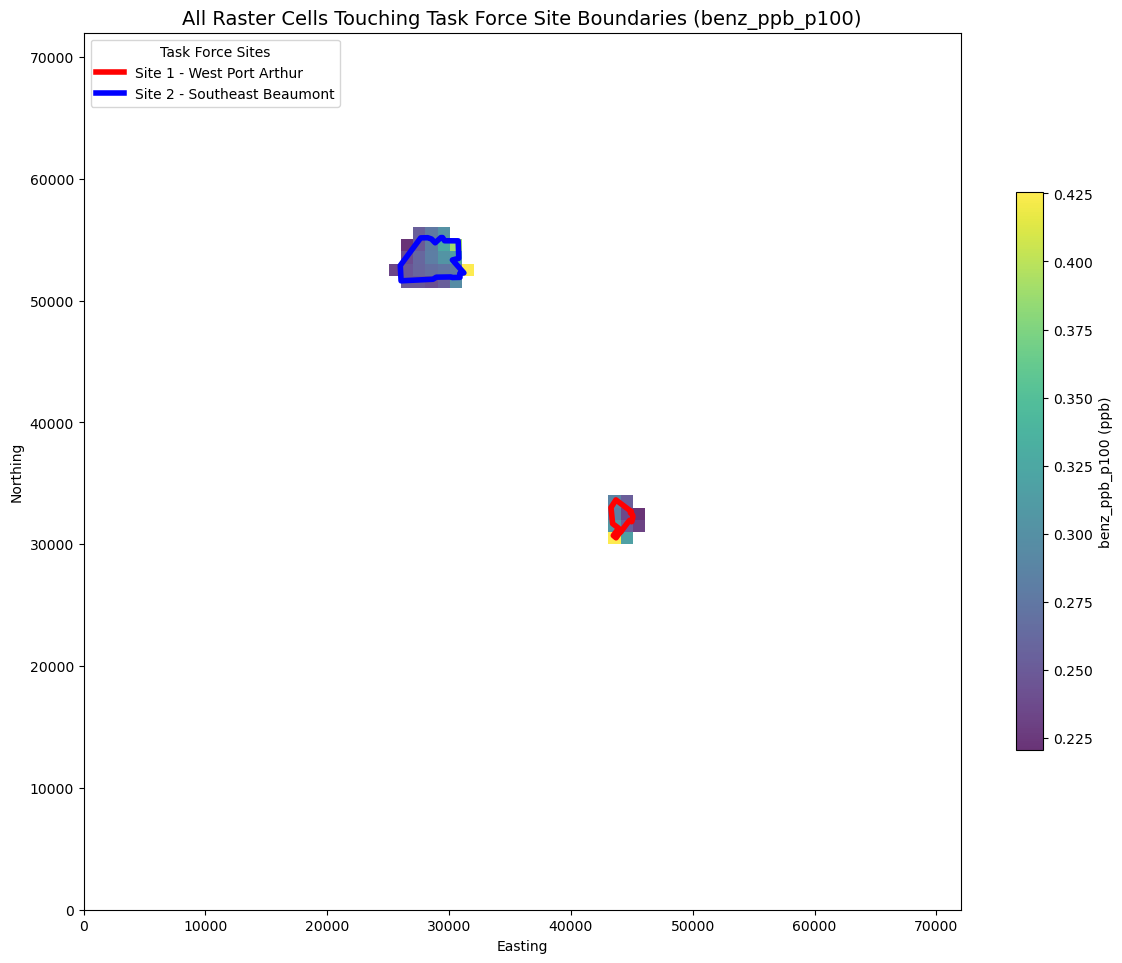


Summary of benz_ppb_p100 exposure by task force site (all touching cells):
----------------------------------------------------------------------
Site 1 (West Port Arthur - Foley Watershed):
  Total cells touching boundary: 10
  benz_ppb_p100 concentration:
    Min:  0.246 ppb
    Max:  0.829 ppb
    Mean: 0.419 ppb

Site 2 (Southeast Beaumont - Hillebrant Bayou/Tenmile Creek-Neches River):
  Total cells touching boundary: 25
  benz_ppb_p100 concentration:
    Min:  0.221 ppb
    Max:  0.425 ppb
    Mean: 0.279 ppb



In [35]:
# Visualize all raster cells that touch the task force site boundaries
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the masked raster data for each site
for site_id, site_data in site_air_pollution_dict.items():
    # Get the masked data
    masked_data = site_data['masked_data']
    
    # Create extent for the full raster
    height, width = masked_data.shape
    extent = [
        raster_data['transform'][2],  # left (min x)
        raster_data['transform'][2] + raster_data['transform'][0] * width,  # right (max x)
        raster_data['transform'][5] + raster_data['transform'][4] * height,  # bottom (min y)
        raster_data['transform'][5]  # top (max y)
    ]
    
    # Plot only the valid (non-NaN) cells for this site
    masked_for_display = np.ma.masked_invalid(masked_data)
    im = ax.imshow(masked_for_display, extent=extent, cmap='viridis', alpha=0.8)

# Add colorbar
plt.colorbar(im, ax=ax, label=f'{first_pollutant} (ppb)', shrink=0.6)

# Transform task force sites to match raster CRS for plotting
tfsites_plot = tfsites_gdf.to_crs(raster_data['crs'])

# Plot task force sites as colored outlines
tfsites_plot.plot(ax=ax, facecolor='none', 
                 edgecolor=['red', 'blue'], linewidth=4,
                 column='Site_Name')

# Create custom legend for site boundaries
import matplotlib.lines as mlines
site1_line = mlines.Line2D([], [], color='red', linewidth=4, label='Site 1 - West Port Arthur')
site2_line = mlines.Line2D([], [], color='blue', linewidth=4, label='Site 2 - Southeast Beaumont')
ax.legend(handles=[site1_line, site2_line], title='Task Force Sites', loc='upper left')

plt.title(f"All Raster Cells Touching Task Force Site Boundaries ({first_pollutant})", fontsize=14)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary of {first_pollutant} exposure by task force site (all touching cells):")
print("-" * 70)
for site_id, site_data in site_air_pollution_dict.items():
    print(f"Site {site_id} ({site_data['site_name']}):")
    print(f"  Total cells touching boundary: {site_data['valid_cells']}")
    print(f"  {site_data['pollutant']} concentration:")
    print(f"    Min:  {site_data['min_value']:.3f} ppb")
    print(f"    Max:  {site_data['max_value']:.3f} ppb") 
    print(f"    Mean: {site_data['mean_value']:.3f} ppb")
    print()

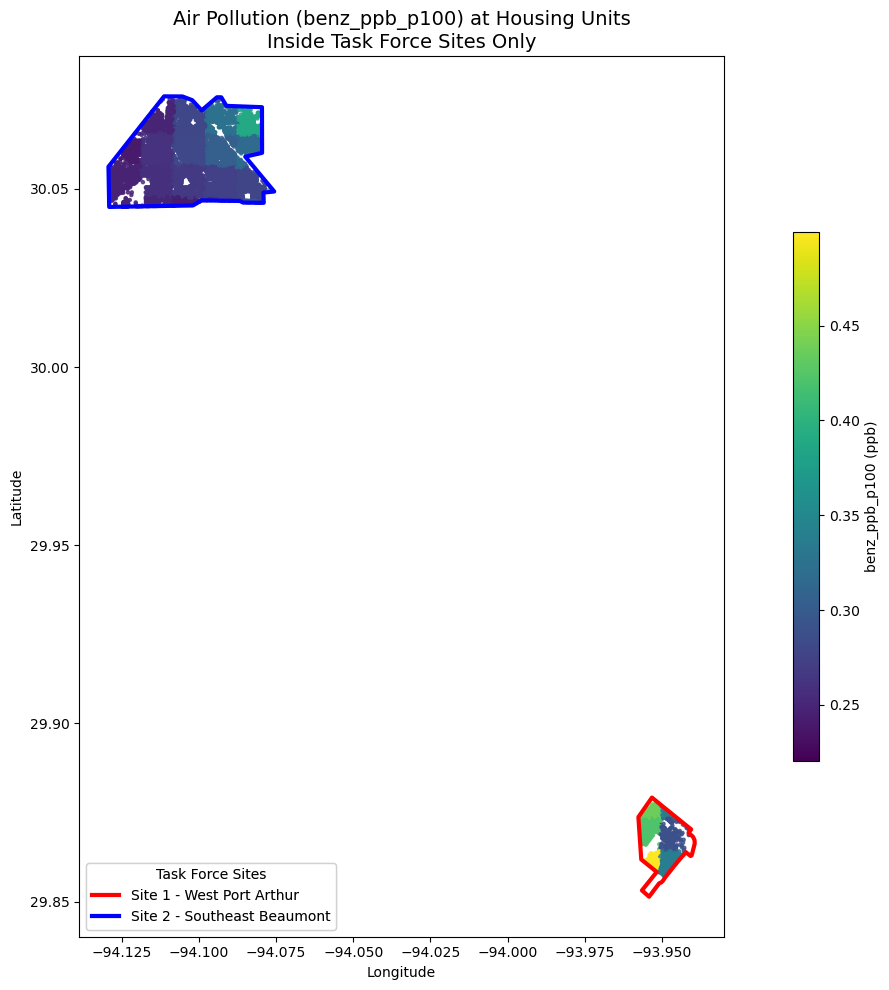

Total housing units inside task force sites: 9666
Housing units with valid benz_ppb_p100 values: 9666
Breakdown by site:
Site_ID
1.0    1223
2.0    8443
dtype: int64


In [36]:
# make maps of the air pollution using the hua_air_gdf data
# Create comprehensive maps showing air pollution at housing unit locations
# Only show HUA points that are INSIDE the task force sites

# Filter to only show housing units inside task force sites
hua_inside_sites = hua_air_gdf[hua_air_gdf['Site_ID'].notna()]

# 1. Overall map of air pollution at housing units INSIDE task force sites
fig, ax = plt.subplots(figsize=(14, 10))

# Plot only housing units inside task force sites, colored by air pollution values
hua_inside_sites.plot(column=f'{first_pollutant}_ppb', ax=ax, legend=True,
                      cmap='viridis', markersize=5, alpha=0.8,
                      legend_kwds={'label': f'{first_pollutant} (ppb)', 'shrink': 0.6})

# Add task force site boundaries
tfsites_gdf.plot(ax=ax, facecolor='none', 
                 edgecolor=['red', 'blue'], linewidth=3,
                 column='Site_Name')

# Create custom legend for site boundaries (moved to lower left)
import matplotlib.lines as mlines
site1_line = mlines.Line2D([], [], color='red', linewidth=3, label='Site 1 - West Port Arthur')
site2_line = mlines.Line2D([], [], color='blue', linewidth=3, label='Site 2 - Southeast Beaumont')
legend1 = ax.legend(handles=[site1_line, site2_line], title='Task Force Sites', 
                   loc='lower left', bbox_to_anchor=(0, 0))
ax.add_artist(legend1)  # Keep both legends

plt.title(f"Air Pollution ({first_pollutant}) at Housing Units\nInside Task Force Sites Only", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

print(f"Total housing units inside task force sites: {len(hua_inside_sites)}")
print(f"Housing units with valid {first_pollutant} values: {hua_inside_sites[f'{first_pollutant}_ppb'].notna().sum()}")
print(f"Breakdown by site:")
print(hua_inside_sites.groupby('Site_ID').size())

C:\Users\nathanael99\AppData\Local\Temp\ipykernel_13228\384633736.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.85, 1])  # Leave space for colorbar and text box


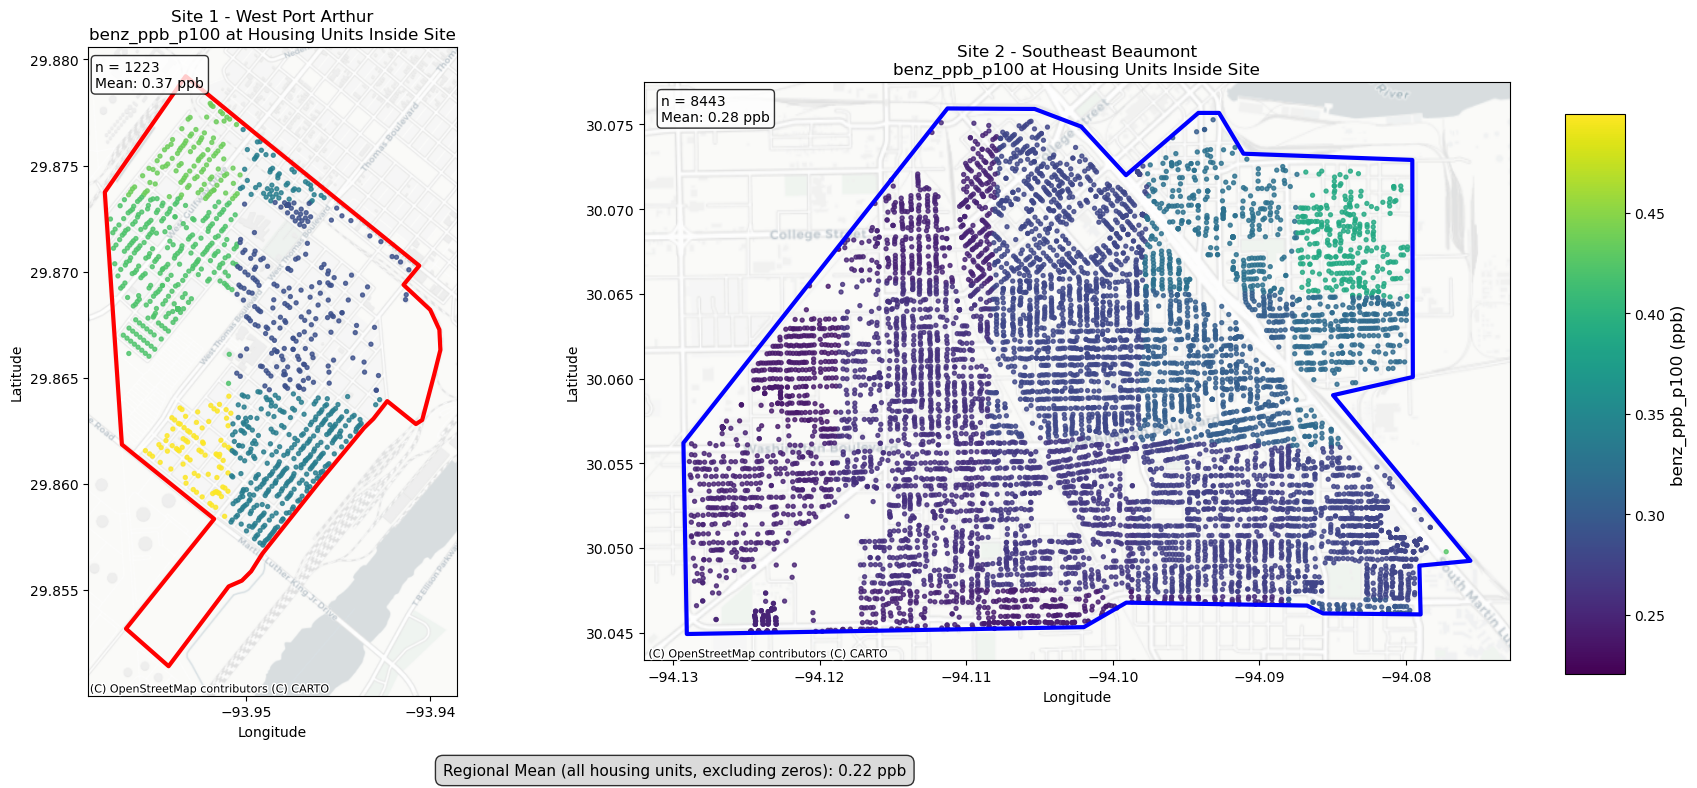


Air Pollution (benz_ppb_p100) Summary - Housing Units Inside Task Force Sites:
Global range: 0.221 - 0.499 ppb (used for consistent scaling)

Background Reference - All Housing Units (excluding zeros):
  Total housing units with valid pollution data: 171911
  benz_ppb_p100 concentration (ppb):
    Mean:   0.222
    Median: 0.203
    Min:    0.144
    Max:    1.121

Site 1 (West Port Arthur - Foley Watershed) - Housing Units Inside Boundary:
  Housing units inside site: 1223
  Valid pollution values: 1223
  benz_ppb_p100 concentration (ppb):
    Min:    0.288
    Max:    0.499
    Mean:   0.370
    Median: 0.337
    Std:    0.065

Site 2 (Southeast Beaumont - Hillebrant Bayou/Tenmile Creek-Neches River) - Housing Units Inside Boundary:
  Housing units inside site: 8443
  Valid pollution values: 8443
  benz_ppb_p100 concentration (ppb):
    Min:    0.221
    Max:    0.425
    Mean:   0.278
    Median: 0.273
    Std:    0.030



In [37]:
# 2. Side-by-side maps for each task force site (housing units inside sites only)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Determine the global min/max values for consistent scaling
pollution_values = hua_inside_sites[f'{first_pollutant}_ppb'].dropna()
if len(pollution_values) > 0:
    vmin = pollution_values.min()
    vmax = pollution_values.max()
else:
    vmin, vmax = 0, 1  # Default range if no data

# Site 1 - West Port Arthur (only HUA points inside the site)
site1_data = hua_inside_sites[hua_inside_sites['Site_ID'] == 1]
if len(site1_data) > 0:
    site1_data.plot(column=f'{first_pollutant}_ppb', ax=axes[0], legend=False,
                    cmap='viridis', markersize=8, alpha=0.8,
                    vmin=vmin, vmax=vmax)
    
    # Add site boundary
    site1_boundary = tfsites_gdf[tfsites_gdf['Site_ID'] == 1]
    site1_boundary.plot(ax=axes[0], facecolor='none', edgecolor='red', linewidth=3)
    
    # Add muted black and white basemap for context
    try:
        ctx.add_basemap(axes[0], crs=site1_data.crs, 
                        source=ctx.providers.CartoDB.Positron, 
                        alpha=0.9, zorder=0)
    except:
        pass  # Continue without basemap if it fails
    
    axes[0].set_title(f'Site 1 - West Port Arthur\n{first_pollutant} at Housing Units Inside Site', fontsize=12)
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    
    # Reduce number of x-axis ticks for cleaner appearance
    axes[0].locator_params(axis='x', nbins=4)
    
    # Add statistics text
    mean_val = site1_data[f'{first_pollutant}_ppb'].mean()
    site1_stats = f"n = {len(site1_data)}\nMean: {mean_val:.2f} ppb"
    axes[0].text(0.02, 0.98, site1_stats, transform=axes[0].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    axes[0].text(0.5, 0.5, 'No housing units inside Site 1', transform=axes[0].transAxes, 
                ha='center', va='center', fontsize=14)
    axes[0].set_title('Site 1 - West Port Arthur (No Housing Units Inside)')

# Site 2 - Southeast Beaumont (only HUA points inside the site)
site2_data = hua_inside_sites[hua_inside_sites['Site_ID'] == 2]
if len(site2_data) > 0:
    im = site2_data.plot(column=f'{first_pollutant}_ppb', ax=axes[1], legend=False,
                         cmap='viridis', markersize=8, alpha=0.8,
                         vmin=vmin, vmax=vmax)
    
    # Add site boundary
    site2_boundary = tfsites_gdf[tfsites_gdf['Site_ID'] == 2]
    site2_boundary.plot(ax=axes[1], facecolor='none', edgecolor='blue', linewidth=3)
    
    # Add muted black and white basemap for context
    try:
        ctx.add_basemap(axes[1], crs=site2_data.crs, 
                        source=ctx.providers.CartoDB.Positron, 
                        alpha=0.9, zorder=0)
    except:
        pass  # Continue without basemap if it fails
    
    axes[1].set_title(f'Site 2 - Southeast Beaumont\n{first_pollutant} at Housing Units Inside Site', fontsize=12)
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    
    # Add statistics text
    mean_val = site2_data[f'{first_pollutant}_ppb'].mean()
    site2_stats = f"n = {len(site2_data)}\nMean: {mean_val:.2f} ppb"
    axes[1].text(0.02, 0.98, site2_stats, transform=axes[1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    axes[1].text(0.5, 0.5, 'No housing units inside Site 2', transform=axes[1].transAxes, 
                ha='center', va='center', fontsize=14)
    axes[1].set_title('Site 2 - Southeast Beaumont (No Housing Units Inside)')

# Add a single colorbar that applies to both subplots
if len(pollution_values) > 0:
    # Create a ScalarMappable for the colorbar
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(norm=norm, cmap='viridis')
    sm.set_array([])
    
    # Create a dedicated axes for the colorbar positioned on the far right
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Adjust the main axes to make room for colorbar
    plt.subplots_adjust(right=0.85)
    
    # Create colorbar axes on the far right
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(f'{first_pollutant} (ppb)', fontsize=12)

# Add regional mean reference text box at bottom of figure
all_hua_pollution = hua_air_gdf[f'{first_pollutant}_ppb'].dropna()
all_hua_nonzero = all_hua_pollution[all_hua_pollution > 0]
if len(all_hua_nonzero) > 0:
    regional_mean = all_hua_nonzero.mean()
    regional_text = f"Regional Mean (all housing units, excluding zeros): {regional_mean:.2f} ppb"
    fig.text(0.425, 0.02, regional_text, ha='center', va='bottom', fontsize=11, 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout(rect=[0, 0.05, 0.85, 1])  # Leave space for colorbar and text box
plt.show()

# Print summary statistics by site (inside sites only)
print(f"\nAir Pollution ({first_pollutant}) Summary - Housing Units Inside Task Force Sites:")
print("=" * 70)
print(f"Global range: {vmin:.3f} - {vmax:.3f} ppb (used for consistent scaling)")
print()

# Calculate overall HUA statistics (excluding zeros and NaN values)
all_hua_pollution = hua_air_gdf[f'{first_pollutant}_ppb'].dropna()
all_hua_nonzero = all_hua_pollution[all_hua_pollution > 0]
if len(all_hua_nonzero) > 0:
    print(f"Background Reference - All Housing Units (excluding zeros):")
    print(f"  Total housing units with valid pollution data: {len(all_hua_nonzero)}")
    print(f"  {first_pollutant} concentration (ppb):")
    print(f"    Mean:   {all_hua_nonzero.mean():.3f}")
    print(f"    Median: {all_hua_nonzero.median():.3f}")
    print(f"    Min:    {all_hua_nonzero.min():.3f}")
    print(f"    Max:    {all_hua_nonzero.max():.3f}")
    print()

for site_id in [1, 2]:
    site_data = hua_inside_sites[hua_inside_sites['Site_ID'] == site_id]
    if len(site_data) > 0:
        site_name = tfsites_gdf[tfsites_gdf['Site_ID'] == site_id]['Site_Name'].iloc[0]
        pollution_values = site_data[f'{first_pollutant}_ppb'].dropna()
        if len(pollution_values) > 0:
            print(f"Site {site_id} ({site_name}) - Housing Units Inside Boundary:")
            print(f"  Housing units inside site: {len(site_data)}")
            print(f"  Valid pollution values: {len(pollution_values)}")
            print(f"  {first_pollutant} concentration (ppb):")
            print(f"    Min:    {pollution_values.min():.3f}")
            print(f"    Max:    {pollution_values.max():.3f}")
            print(f"    Mean:   {pollution_values.mean():.3f}")
            print(f"    Median: {pollution_values.median():.3f}")
            print(f"    Std:    {pollution_values.std():.3f}")
            print()
        else:
            print(f"Site {site_id}: Housing units inside but no valid pollution data")
    else:
        print(f"Site {site_id}: No housing units found inside the site boundary")

In [38]:
# describe results by Site_ID
hua_tfsites_gdf.groupby('Site_ID').size()

Site_ID
1.0    1223
2.0    8443
dtype: int64

<Axes: >

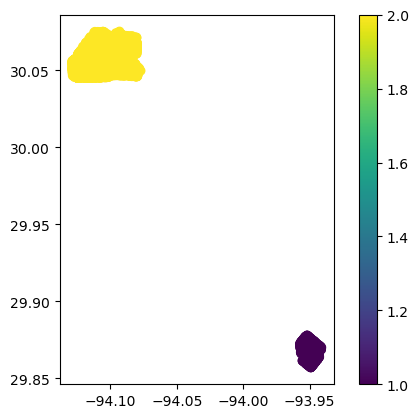

In [39]:
# plot points by Site_ID
hua_tfsites_gdf.plot(column='Site_ID', legend=True)

### Add Low-income renter variable

In [53]:
# Create a new variable that identifies low-income renters
# Low income defined as below median randincome

# First, add tenure status and household income group to the data
hua_air_gdf_with_demographics = PopResultsTable.add_hhinc_df(hua_air_gdf)
hua_air_gdf_with_demographics = PopResultsTable.add_tenure_to_pop_df(hua_air_gdf_with_demographics)

# Calculate median income for the region (excluding missing values)
median_income = hua_air_gdf_with_demographics['randincome'].median()
print(f"Regional median household income: ${median_income:,.0f}")

# Create low-income renter variable
def add_low_income_renter_variable(df):
    """Add Low Income Renter status to dataframe.
    
    Args:
        df (obj): Pandas DataFrame object with randincome and ownershp columns.
    
    Returns:
        object: Pandas DataFrame object with new Low Income Renter Status column.
    """
    # Calculate median income if not already calculated
    median_income = df['randincome'].median()
    
    # Initialize the variable
    df['Low Income Renter Status'] = "Not Low Income Renter"
    df['Low Income Renter Status'].notes = "Identify Low Income Renter Status based on below median income and renter status."
    
    # Define low-income renters: ownershp=2 (renter) AND randincome < median
    low_income_renter_condition = (df['ownershp'] == 2) & (df['randincome'] < median_income) & (df['randincome'].notna())
    df.loc[low_income_renter_condition, 'Low Income Renter Status'] = "Low Income Renter"
    
    # Set to missing for cases with missing income or ownership data
    missing_data_condition = df['randincome'].isna() | df['ownershp'].isna()
    df.loc[missing_data_condition, 'Low Income Renter Status'] = np.nan
    
    return df

# Apply the function
hua_air_gdf_with_demographics = add_low_income_renter_variable(hua_air_gdf_with_demographics)

# Check the results
print(f"\nLow Income Renter Status distribution:")
print(hua_air_gdf_with_demographics['Low Income Renter Status'].value_counts(dropna=False))

# Cross-tabulation to verify the logic
print(f"\nCross-tabulation of Tenure Status vs Low Income Renter Status:")
crosstab = pd.crosstab(
    hua_air_gdf_with_demographics['Tenure Status'], 
    hua_air_gdf_with_demographics['Low Income Renter Status'], 
    margins=True, 
    dropna=False
)
print(crosstab)

# Show some summary statistics
low_income_renters = hua_air_gdf_with_demographics[hua_air_gdf_with_demographics['Low Income Renter Status'] == 'Low Income Renter']
if len(low_income_renters) > 0:
    print(f"\nLow-income renter households:")
    print(f"  Count: {len(low_income_renters):,}")
    print(f"  Mean income: ${low_income_renters['randincome'].mean():,.0f}")
    print(f"  Median income: ${low_income_renters['randincome'].median():,.0f}")
    print(f"  Income range: ${low_income_renters['randincome'].min():,.0f} - ${low_income_renters['randincome'].max():,.0f}")

# Show income distribution by income group for low-income renters
if 'Household Income Group' in hua_air_gdf_with_demographics.columns:
    print(f"\nLow-income renters by Household Income Group:")
    income_group_crosstab = pd.crosstab(
        hua_air_gdf_with_demographics['Household Income Group'], 
        hua_air_gdf_with_demographics['Low Income Renter Status'], 
        margins=True, 
        dropna=False
    )
    print(income_group_crosstab)

Regional median household income: $60,412

Low Income Renter Status distribution:
Low Income Renter Status
Not Low Income Renter    136545
NaN                       58811
Low Income Renter         31569
Name: count, dtype: int64

Cross-tabulation of Tenure Status vs Low Income Renter Status:
Low Income Renter Status  Low Income Renter  Not Low Income Renter    NaN  \
Tenure Status                                                               
1 Owner Occupied                          0                 113927      0   
2 Renter Occupied                     31569                  22618      0   
NaN                                       0                      0  58811   
All                                   31569                 136545      0   

Low Income Renter Status       All  
Tenure Status                       
1 Owner Occupied          113927.0  
2 Renter Occupied          54187.0  
NaN                            NaN  
All                       226925.0  

Low-income renter hou

#### Look at air pollution using ANOVAs

In [58]:
# Run ANOVA test on hua_air_gdf using the ownership variable 
# 1 = owner occupied and 2 = renter occupied

import scipy.stats as stats
import numpy as np

# First, let's check the ownership variable in the data
print("Checking ownership variable in hua_air_gdf:")
print(f"Available columns: {list(hua_air_gdf.columns)}")

# Look for ownership-related columns
ownership_cols = [col for col in hua_air_gdf.columns if 'owner' in col.lower() or 'tenure' in col.lower() or 'rent' in col.lower()]
print(f"Potential ownership columns: {ownership_cols}")

# Check if we have the ownership variable
if 'ownershp' in hua_air_gdf.columns:
    print(f"\nOwnership variable found: 'ownershp'")
    print(f"Unique values: {hua_air_gdf['ownershp'].unique()}")
    print(f"Value counts:\n{hua_air_gdf['ownershp'].value_counts()}")
    
    # Check if we have air pollution data
    pollution_col = f'{first_pollutant}_ppb'
    if pollution_col in hua_air_gdf.columns:
        print(f"\nAir pollution data found: '{pollution_col}'")
        
        # Prepare data for ANOVA - exclude zeros since they are outside the model domain
        analysis_df = hua_air_gdf[[pollution_col, 'ownershp']].dropna()
        analysis_df = analysis_df[analysis_df[pollution_col] > 0]
        
        print(f"\n=== DATA SUMMARY ===")
        print(f"Total records with valid pollution and ownership data (excluding zeros): {len(analysis_df)}")
        print(f"Note: Zero values excluded as they represent areas outside the pollution model domain")
        
        print(f"\n" + "="*60)
        print(f"ANOVA ANALYSIS - NON-ZERO POLLUTION VALUES ONLY")
        print(f"="*60)
        
        print(f"Sample size for ANOVA: {len(analysis_df)}")
        print(f"Owner-occupied units (1): {(analysis_df['ownershp'] == 1).sum()}")
        print(f"Renter-occupied units (2): {(analysis_df['ownershp'] == 2).sum()}")
        
        if len(analysis_df) > 0 and analysis_df['ownershp'].nunique() >= 2:
            # Split data by ownership type
            owner_occupied = analysis_df[analysis_df['ownershp'] == 1][pollution_col]
            renter_occupied = analysis_df[analysis_df['ownershp'] == 2][pollution_col]
            
            if len(owner_occupied) > 0 and len(renter_occupied) > 0:
                # Calculate descriptive statistics
                print(f"\n--- Descriptive Statistics for {first_pollutant} by Ownership ---")
                print(f"Owner-Occupied (n={len(owner_occupied)}):")
                print(f"  Mean: {owner_occupied.mean():.4f} ppb")
                print(f"  Std:  {owner_occupied.std():.4f} ppb")
                print(f"  Min:  {owner_occupied.min():.4f} ppb")
                print(f"  Max:  {owner_occupied.max():.4f} ppb")
                
                print(f"Renter-Occupied (n={len(renter_occupied)}):")
                print(f"  Mean: {renter_occupied.mean():.4f} ppb")
                print(f"  Std:  {renter_occupied.std():.4f} ppb")
                print(f"  Min:  {renter_occupied.min():.4f} ppb")
                print(f"  Max:  {renter_occupied.max():.4f} ppb")
                
                # Run one-way ANOVA
                print(f"\n--- One-Way ANOVA Results ---")
                f_statistic, p_value = stats.f_oneway(owner_occupied, renter_occupied)
                
                print(f"F-statistic: {f_statistic:.4f}")
                print(f"p-value: {p_value:.6f}")
                
                # Interpretation
                alpha = 0.05
                if p_value < alpha:
                    print(f"Result: Significant difference (p < {alpha})")
                    print(f"There IS a statistically significant difference in {first_pollutant} exposure")
                    print(f"between owner-occupied and renter-occupied housing units.")
                else:
                    print(f"Result: No significant difference (p >= {alpha})")
                    print(f"There is NO statistically significant difference in {first_pollutant} exposure")
                    print(f"between owner-occupied and renter-occupied housing units.")
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(owner_occupied) - 1) * owner_occupied.var() + 
                                    (len(renter_occupied) - 1) * renter_occupied.var()) / 
                                   (len(owner_occupied) + len(renter_occupied) - 2))
                
                if pooled_std > 0:
                    cohens_d = (owner_occupied.mean() - renter_occupied.mean()) / pooled_std
                    print(f"Cohen's d (effect size): {cohens_d:.4f}")
                    
                    # Interpretation of effect size
                    if abs(cohens_d) < 0.2:
                        effect_size_interpretation = "negligible"
                    elif abs(cohens_d) < 0.5:
                        effect_size_interpretation = "small"
                    elif abs(cohens_d) < 0.8:
                        effect_size_interpretation = "medium"
                    else:
                        effect_size_interpretation = "large"
                    
                    print(f"Effect size interpretation: {effect_size_interpretation}")
                    
                    if cohens_d > 0:
                        print("Direction: Owner-occupied units have HIGHER pollution exposure")
                    else:
                        print("Direction: Renter-occupied units have HIGHER pollution exposure")
                else:
                    print("Cannot calculate Cohen's d (pooled standard deviation is 0)")
                
                # Additional test: Levene's test for equal variances
                levene_stat, levene_p = stats.levene(owner_occupied, renter_occupied)
                print(f"\n--- Levene's Test for Equal Variances ---")
                print(f"Levene's statistic: {levene_stat:.4f}")
                print(f"p-value: {levene_p:.6f}")
                if levene_p < 0.05:
                    print("Warning: Variances are significantly different (ANOVA assumption violated)")
                    # Run Welch's t-test as alternative
                    welch_stat, welch_p = stats.ttest_ind(owner_occupied, renter_occupied, equal_var=False)
                    print(f"\nWelch's t-test (unequal variances):")
                    print(f"t-statistic: {welch_stat:.4f}")
                    print(f"p-value: {welch_p:.6f}")
                else:
                    print("Variances are not significantly different (ANOVA assumption met)")
            else:
                print(f"Insufficient data: Owner-occupied n={len(owner_occupied)}, Renter-occupied n={len(renter_occupied)}")
        else:
            print("Insufficient data for ANOVA analysis")
    else:
        print(f"Air pollution column '{pollution_col}' not found in the data")
else:
    # Check alternative column names
    possible_ownership_cols = ['tenure', 'tenure_status', 'ownrshp', 'ownership']
    found_col = None
    for col in possible_ownership_cols:
        if col in hua_air_gdf.columns:
            found_col = col
            break
    
    if found_col:
        print(f"Alternative ownership column found: '{found_col}'")
        print(f"Values: {hua_air_gdf[found_col].unique()}")
    else:
        print("No ownership variable found. Available columns:")
        for col in sorted(hua_air_gdf.columns):
            print(f"  {col}")

Checking ownership variable in hua_air_gdf:
Available columns: ['huid', 'Block2020', 'blockid', 'bgid', 'tractid', 'FIPScounty', 'numprec', 'ownershp', 'race', 'hispan', 'family', 'vacancy', 'gqtype', 'incomegroup', 'hhinc', 'randincome', 'poverty', 'BLOCKID20_str', 'huicounter1', 'huicounter2', 'huicounter3', 'ownershp1', 'ownershp2', 'ownershp3', 'strctid', 'strctid_flagsetrm', 'strctid_Block2020_flagsetrm', 'addrptid', 'fd_id_bid', 'huestimate', 'huicounter_addpt', 'placeNAME20', 'x', 'y', 'occtype', 'geometry', 'index_right', 'Site_ID', 'Site_Name', 'benz_ppb_p100_ppb', 'Household Income Group', 'Race Ethnicity', 'Tenure Status', 'Low Income Renter Status']
Potential ownership columns: ['ownershp', 'ownershp1', 'ownershp2', 'ownershp3', 'Tenure Status', 'Low Income Renter Status']

Ownership variable found: 'ownershp'
Unique values: [nan  2.  1.]
Value counts:
ownershp
1.0    113927
2.0     54187
Name: count, dtype: int64

Air pollution data found: 'benz_ppb_p100_ppb'

=== DATA SUM

In [54]:
# Run ANOVA test on hua_air_gdf using the ownership variable 
# 1 = owner occupied and 2 = renter occupied

import scipy.stats as stats
import numpy as np

# First, let's check the ownership variable in the data
print("Checking ownership variable in hua_air_gdf:")
print(f"Available columns: {list(hua_air_gdf.columns)}")

# Look for ownership-related columns
ownership_cols = [col for col in hua_air_gdf.columns if 'owner' in col.lower() or 'tenure' in col.lower() or 'rent' in col.lower()]
print(f"Potential ownership columns: {ownership_cols}")

# Check if we have the ownership variable
if 'ownershp' in hua_air_gdf.columns:
    print(f"\nOwnership variable found: 'ownershp'")
    print(f"Unique values: {hua_air_gdf['ownershp'].unique()}")
    print(f"Value counts:\n{hua_air_gdf['ownershp'].value_counts()}")
    
    # Check if we have air pollution data
    pollution_col = f'{first_pollutant}_ppb'
    if pollution_col in hua_air_gdf.columns:
        print(f"\nAir pollution data found: '{pollution_col}'")
        
        # Prepare data for ANOVA - exclude zeros since they are outside the model domain
        analysis_df = hua_air_gdf[[pollution_col, 'ownershp']].dropna()
        analysis_df = analysis_df[analysis_df[pollution_col] > 0]
        
        print(f"\n=== DATA SUMMARY ===")
        print(f"Total records with valid pollution and ownership data (excluding zeros): {len(analysis_df)}")
        print(f"Note: Zero values excluded as they represent areas outside the pollution model domain")
        
        print(f"\n" + "="*60)
        print(f"ANOVA ANALYSIS - NON-ZERO POLLUTION VALUES ONLY")
        print(f"="*60)
        
        print(f"Sample size for ANOVA: {len(analysis_df)}")
        print(f"Owner-occupied units (1): {(analysis_df['ownershp'] == 1).sum()}")
        print(f"Renter-occupied units (2): {(analysis_df['ownershp'] == 2).sum()}")
        
        if len(analysis_df) > 0 and analysis_df['ownershp'].nunique() >= 2:
            # Split data by ownership type
            owner_occupied = analysis_df[analysis_df['ownershp'] == 1][pollution_col]
            renter_occupied = analysis_df[analysis_df['ownershp'] == 2][pollution_col]
            
            if len(owner_occupied) > 0 and len(renter_occupied) > 0:
                # Calculate descriptive statistics
                print(f"\n--- Descriptive Statistics for {first_pollutant} by Ownership ---")
                print(f"Owner-Occupied (n={len(owner_occupied)}):")
                print(f"  Mean: {owner_occupied.mean():.4f} ppb")
                print(f"  Std:  {owner_occupied.std():.4f} ppb")
                print(f"  Min:  {owner_occupied.min():.4f} ppb")
                print(f"  Max:  {owner_occupied.max():.4f} ppb")
                
                print(f"Renter-Occupied (n={len(renter_occupied)}):")
                print(f"  Mean: {renter_occupied.mean():.4f} ppb")
                print(f"  Std:  {renter_occupied.std():.4f} ppb")
                print(f"  Min:  {renter_occupied.min():.4f} ppb")
                print(f"  Max:  {renter_occupied.max():.4f} ppb")
                
                # Run one-way ANOVA
                print(f"\n--- One-Way ANOVA Results ---")
                f_statistic, p_value = stats.f_oneway(owner_occupied, renter_occupied)
                
                print(f"F-statistic: {f_statistic:.4f}")
                print(f"p-value: {p_value:.6f}")
                
                # Interpretation
                alpha = 0.05
                if p_value < alpha:
                    print(f"Result: Significant difference (p < {alpha})")
                    print(f"There IS a statistically significant difference in {first_pollutant} exposure")
                    print(f"between owner-occupied and renter-occupied housing units.")
                else:
                    print(f"Result: No significant difference (p >= {alpha})")
                    print(f"There is NO statistically significant difference in {first_pollutant} exposure")
                    print(f"between owner-occupied and renter-occupied housing units.")
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(owner_occupied) - 1) * owner_occupied.var() + 
                                    (len(renter_occupied) - 1) * renter_occupied.var()) / 
                                   (len(owner_occupied) + len(renter_occupied) - 2))
                
                if pooled_std > 0:
                    cohens_d = (owner_occupied.mean() - renter_occupied.mean()) / pooled_std
                    print(f"Cohen's d (effect size): {cohens_d:.4f}")
                    
                    # Interpretation of effect size
                    if abs(cohens_d) < 0.2:
                        effect_size_interpretation = "negligible"
                    elif abs(cohens_d) < 0.5:
                        effect_size_interpretation = "small"
                    elif abs(cohens_d) < 0.8:
                        effect_size_interpretation = "medium"
                    else:
                        effect_size_interpretation = "large"
                    
                    print(f"Effect size interpretation: {effect_size_interpretation}")
                    
                    if cohens_d > 0:
                        print("Direction: Owner-occupied units have HIGHER pollution exposure")
                    else:
                        print("Direction: Renter-occupied units have HIGHER pollution exposure")
                else:
                    print("Cannot calculate Cohen's d (pooled standard deviation is 0)")
                
                # Additional test: Levene's test for equal variances
                levene_stat, levene_p = stats.levene(owner_occupied, renter_occupied)
                print(f"\n--- Levene's Test for Equal Variances ---")
                print(f"Levene's statistic: {levene_stat:.4f}")
                print(f"p-value: {levene_p:.6f}")
                if levene_p < 0.05:
                    print("Warning: Variances are significantly different (ANOVA assumption violated)")
                    # Run Welch's t-test as alternative
                    welch_stat, welch_p = stats.ttest_ind(owner_occupied, renter_occupied, equal_var=False)
                    print(f"\nWelch's t-test (unequal variances):")
                    print(f"t-statistic: {welch_stat:.4f}")
                    print(f"p-value: {welch_p:.6f}")
                else:
                    print("Variances are not significantly different (ANOVA assumption met)")
            else:
                print(f"Insufficient data: Owner-occupied n={len(owner_occupied)}, Renter-occupied n={len(renter_occupied)}")
        else:
            print("Insufficient data for ANOVA analysis")
    else:
        print(f"Air pollution column '{pollution_col}' not found in the data")
else:
    # Check alternative column names
    possible_ownership_cols = ['tenure', 'tenure_status', 'ownrshp', 'ownership']
    found_col = None
    for col in possible_ownership_cols:
        if col in hua_air_gdf.columns:
            found_col = col
            break
    
    if found_col:
        print(f"Alternative ownership column found: '{found_col}'")
        print(f"Values: {hua_air_gdf[found_col].unique()}")
    else:
        print("No ownership variable found. Available columns:")
        for col in sorted(hua_air_gdf.columns):
            print(f"  {col}")

Checking ownership variable in hua_air_gdf:
Available columns: ['huid', 'Block2020', 'blockid', 'bgid', 'tractid', 'FIPScounty', 'numprec', 'ownershp', 'race', 'hispan', 'family', 'vacancy', 'gqtype', 'incomegroup', 'hhinc', 'randincome', 'poverty', 'BLOCKID20_str', 'huicounter1', 'huicounter2', 'huicounter3', 'ownershp1', 'ownershp2', 'ownershp3', 'strctid', 'strctid_flagsetrm', 'strctid_Block2020_flagsetrm', 'addrptid', 'fd_id_bid', 'huestimate', 'huicounter_addpt', 'placeNAME20', 'x', 'y', 'occtype', 'geometry', 'index_right', 'Site_ID', 'Site_Name', 'benz_ppb_p100_ppb', 'Household Income Group', 'Race Ethnicity', 'Tenure Status', 'Low Income Renter Status']
Potential ownership columns: ['ownershp', 'ownershp1', 'ownershp2', 'ownershp3', 'Tenure Status', 'Low Income Renter Status']

Ownership variable found: 'ownershp'
Unique values: [nan  2.  1.]
Value counts:
ownershp
1.0    113927
2.0     54187
Name: count, dtype: int64

Air pollution data found: 'benz_ppb_p100_ppb'

=== DATA SUM

In [41]:
# Run ANOVA analysis by income groups - new variable 'Household Income Group'
# First, add income groups to the data
hua_air_gdf_with_income = PopResultsTable.add_hhinc_df(hua_air_gdf)

# Check the income groups variable
print("Checking household income group variable:")
if 'Household Income Group' in hua_air_gdf_with_income.columns:
    print(f"\nIncome group variable found: 'Household Income Group'")
    print(f"Unique values: {hua_air_gdf_with_income['Household Income Group'].unique()}")
    print(f"Value counts:\n{hua_air_gdf_with_income['Household Income Group'].value_counts()}")
    
    # Check if we have air pollution data
    pollution_col = f'{first_pollutant}_ppb'
    if pollution_col in hua_air_gdf_with_income.columns:
        print(f"\nAir pollution data found: '{pollution_col}'")
        
        # Prepare data for ANOVA - exclude zeros since they are outside the model domain
        analysis_df = hua_air_gdf_with_income[[pollution_col, 'Household Income Group']].dropna()
        analysis_df = analysis_df[analysis_df[pollution_col] > 0]
        
        print(f"\n=== DATA SUMMARY ===")
        print(f"Total records with valid pollution and income data (excluding zeros): {len(analysis_df)}")
        print(f"Note: Zero values excluded as they represent areas outside the pollution model domain")
        
        # Count by income group
        income_counts = analysis_df['Household Income Group'].value_counts()
        print(f"\nSample size by income group:")
        for income_group, count in income_counts.items():
            print(f"  {income_group}: {count}")
        
        print(f"\n" + "="*60)
        print(f"ANOVA ANALYSIS BY HOUSEHOLD INCOME GROUP - NON-ZERO POLLUTION VALUES ONLY")
        print(f"="*60)
        
        if len(analysis_df) > 0 and analysis_df['Household Income Group'].nunique() >= 2:
            # Get unique income groups
            income_groups = analysis_df['Household Income Group'].unique()
            
            # Create a list to store data for each income group
            income_group_data = []
            for group in income_groups:
                group_data = analysis_df[analysis_df['Household Income Group'] == group][pollution_col]
                if len(group_data) > 0:
                    income_group_data.append(group_data.values)  # Convert to numpy array to avoid Series issues
                    
                    # Print descriptive statistics for each group
                    print(f"\n--- {group} (n={len(group_data)}) ---")
                    print(f"  Mean: {group_data.mean():.4f} ppb")
                    print(f"  Std:  {group_data.std():.4f} ppb")
                    print(f"  Min:  {group_data.min():.4f} ppb")
                    print(f"  Max:  {group_data.max():.4f} ppb")
            
            # Run one-way ANOVA if we have at least 2 groups with data
            if len(income_group_data) >= 2:
                print(f"\n--- One-Way ANOVA Results ---")
                try:
                    f_statistic, p_value = stats.f_oneway(*income_group_data)
                    
                    print(f"F-statistic: {f_statistic:.4f}")
                    print(f"p-value: {p_value:.6f}")
                    
                    # Interpretation
                    alpha = 0.05
                    if p_value < alpha:
                        print(f"Result: Significant difference (p < {alpha})")
                        print(f"There IS a statistically significant difference in {first_pollutant} exposure")
                        print(f"across different household income groups.")
                    else:
                        print(f"Result: No significant difference (p >= {alpha})")
                        print(f"There is NO statistically significant difference in {first_pollutant} exposure")
                        print(f"across different household income groups.")
                    
                    # Calculate effect size (eta-squared)
                    # SS_between / SS_total
                    group_means = [np.mean(group) for group in income_group_data]
                    overall_mean = analysis_df[pollution_col].mean()
                    
                    # Between-group sum of squares
                    ss_between = sum([len(group) * (np.mean(group) - overall_mean)**2 for group in income_group_data])
                    
                    # Total sum of squares
                    ss_total = ((analysis_df[pollution_col] - overall_mean)**2).sum()
                    
                    if ss_total > 0:
                        eta_squared = ss_between / ss_total
                        print(f"Eta-squared (effect size): {eta_squared:.4f}")
                        
                        # Interpretation of effect size
                        if eta_squared < 0.01:
                            effect_size_interpretation = "negligible"
                        elif eta_squared < 0.06:
                            effect_size_interpretation = "small"
                        elif eta_squared < 0.14:
                            effect_size_interpretation = "medium"
                        else:
                            effect_size_interpretation = "large"
                        
                        print(f"Effect size interpretation: {effect_size_interpretation}")
                    
                    # Additional test: Levene's test for equal variances
                    levene_stat, levene_p = stats.levene(*income_group_data)
                    print(f"\n--- Levene's Test for Equal Variances ---")
                    print(f"Levene's statistic: {levene_stat:.4f}")
                    print(f"p-value: {levene_p:.6f}")
                    if levene_p < 0.05:
                        print("Warning: Variances are significantly different (ANOVA assumption violated)")
                        print("Consider using Welch's ANOVA for unequal variances or non-parametric Kruskal-Wallis test")
                    else:
                        print("Variances are not significantly different (ANOVA assumption met)")
                    
                    # If significant, run post-hoc pairwise comparisons
                    if p_value < alpha and len(income_group_data) > 2:
                        print(f"\n--- Post-hoc Pairwise Comparisons (Tukey HSD) ---")
                        from scipy.stats import tukey_hsd
                        
                        try:
                            # Run Tukey HSD test
                            tukey_result = tukey_hsd(*income_group_data)
                            print("Pairwise comparison results:")
                            
                            # Create a mapping of indices to group names
                            group_names = []
                            for group in income_groups:
                                group_subset = analysis_df[analysis_df['Household Income Group'] == group]
                                if len(group_subset[pollution_col]) > 0:
                                    group_names.append(group)
                            
                            for i in range(len(group_names)):
                                for j in range(i+1, len(group_names)):
                                    pvalue = tukey_result.pvalue[i, j]
                                    statistic = tukey_result.statistic[i, j]
                                    print(f"  {group_names[i]} vs {group_names[j]}: statistic={statistic:.4f}, p-value={pvalue:.6f}")
                                    if pvalue < 0.05:
                                        print(f"    -> Significant difference")
                                    else:
                                        print(f"    -> No significant difference")
                        except Exception as e:
                            print(f"Could not run Tukey HSD test: {e}")
                
                except Exception as e:
                    print(f"Error running ANOVA: {e}")
                    print("This might be due to insufficient variation in the data or other statistical issues.")
            else:
                print("Insufficient income groups with data for ANOVA analysis")
        else:
            print("Insufficient data for ANOVA analysis")
    else:
        print(f"Air pollution column '{pollution_col}' not found in the data")
else:
    print("Household Income Group column not found after adding income data")

Checking household income group variable:

Income group variable found: 'Household Income Group'
Unique values: [nan '5 $100,000 or more' '4 $75,000 to $99,999' '3 $25,000 to $74,999'
 '1 Less than $15,000' '2 $15,000 to $24,999']
Value counts:
Household Income Group
3 $25,000 to $74,999    64520
5 $100,000 or more      49494
4 $75,000 to $99,999    19454
1 Less than $15,000     19082
2 $15,000 to $24,999    15564
Name: count, dtype: int64

Air pollution data found: 'benz_ppb_p100_ppb'

=== DATA SUMMARY ===
Total records with valid pollution and income data (excluding zeros): 129652
Note: Zero values excluded as they represent areas outside the pollution model domain

Sample size by income group:
  3 $25,000 to $74,999: 50285
  5 $100,000 or more: 38970
  4 $75,000 to $99,999: 14760
  1 Less than $15,000: 14526
  2 $15,000 to $24,999: 11111

ANOVA ANALYSIS BY HOUSEHOLD INCOME GROUP - NON-ZERO POLLUTION VALUES ONLY

--- 2 $15,000 to $24,999 (n=11111) ---
  Mean: 0.2216 ppb
  Std:  0.051

In [60]:
# Run ANOVA analysis using the Low Income Renter variable
# Compare air pollution exposure between low-income renters and all others

# Use the dataset with demographic variables that we created earlier
print("Checking low income renter variable:")
if 'Low Income Renter Status' in hua_air_gdf_with_demographics.columns:
    print(f"\nLow Income Renter variable found: 'Low Income Renter Status'")
    print(f"Unique values: {hua_air_gdf_with_demographics['Low Income Renter Status'].unique()}")
    print(f"Value counts:\n{hua_air_gdf_with_demographics['Low Income Renter Status'].value_counts(dropna=False)}")
    
    # Check if we have air pollution data
    pollution_col = f'{first_pollutant}_ppb'
    if pollution_col in hua_air_gdf_with_demographics.columns:
        print(f"\nAir pollution data found: '{pollution_col}'")
        
        # Prepare data for ANOVA - exclude zeros since they are outside the model domain
        analysis_df = hua_air_gdf_with_demographics[[pollution_col, 'Low Income Renter Status']].dropna()
        analysis_df = analysis_df[analysis_df[pollution_col] > 0]
        
        print(f"\n=== DATA SUMMARY ===")
        print(f"Total records with valid pollution and low income renter data (excluding zeros): {len(analysis_df)}")
        print(f"Note: Zero values excluded as they represent areas outside the pollution model domain")
        
        print(f"\n" + "="*60)
        print(f"ANOVA ANALYSIS - LOW INCOME RENTERS vs OTHERS - NON-ZERO POLLUTION VALUES ONLY")
        print(f"="*60)
        
        print(f"Sample size for ANOVA: {len(analysis_df)}")
        print(f"Low Income Renters: {(analysis_df['Low Income Renter Status'] == 'Low Income Renter').sum()}")
        print(f"Not Low Income Renters: {(analysis_df['Low Income Renter Status'] == 'Not Low Income Renter').sum()}")
        
        if len(analysis_df) > 0 and analysis_df['Low Income Renter Status'].nunique() >= 2:
            # Split data by low income renter status
            low_income_renters = analysis_df[analysis_df['Low Income Renter Status'] == 'Low Income Renter'][pollution_col]
            not_low_income_renters = analysis_df[analysis_df['Low Income Renter Status'] == 'Not Low Income Renter'][pollution_col]
            
            if len(low_income_renters) > 0 and len(not_low_income_renters) > 0:
                # Calculate descriptive statistics
                print(f"\n--- Descriptive Statistics for {first_pollutant} by Low Income Renter Status ---")
                print(f"Low Income Renters (n={len(low_income_renters)}):")
                print(f"  Mean: {low_income_renters.mean():.4f} ppb")
                print(f"  Std:  {low_income_renters.std():.4f} ppb")
                print(f"  Min:  {low_income_renters.min():.4f} ppb")
                print(f"  Max:  {low_income_renters.max():.4f} ppb")
                
                print(f"Not Low Income Renters (n={len(not_low_income_renters)}):")
                print(f"  Mean: {not_low_income_renters.mean():.4f} ppb")
                print(f"  Std:  {not_low_income_renters.std():.4f} ppb")
                print(f"  Min:  {not_low_income_renters.min():.4f} ppb")
                print(f"  Max:  {not_low_income_renters.max():.4f} ppb")
                
                # Run one-way ANOVA
                print(f"\n--- One-Way ANOVA Results ---")
                f_statistic, p_value = stats.f_oneway(low_income_renters, not_low_income_renters)
                
                print(f"F-statistic: {f_statistic:.4f}")
                print(f"p-value: {p_value:.6f}")
                
                # Interpretation
                alpha = 0.05
                if p_value < alpha:
                    print(f"Result: Significant difference (p < {alpha})")
                    print(f"There IS a statistically significant difference in {first_pollutant} exposure")
                    print(f"between low-income renters and all others.")
                else:
                    print(f"Result: No significant difference (p >= {alpha})")
                    print(f"There is NO statistically significant difference in {first_pollutant} exposure")
                    print(f"between low-income renters and all others.")
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(low_income_renters) - 1) * low_income_renters.var() + 
                                    (len(not_low_income_renters) - 1) * not_low_income_renters.var()) / 
                                   (len(low_income_renters) + len(not_low_income_renters) - 2))
                
                if pooled_std > 0:
                    cohens_d = (low_income_renters.mean() - not_low_income_renters.mean()) / pooled_std
                    print(f"Cohen's d (effect size): {cohens_d:.4f}")
                    
                    # Interpretation of effect size
                    if abs(cohens_d) < 0.2:
                        effect_size_interpretation = "negligible"
                    elif abs(cohens_d) < 0.5:
                        effect_size_interpretation = "small"
                    elif abs(cohens_d) < 0.8:
                        effect_size_interpretation = "medium"
                    else:
                        effect_size_interpretation = "large"
                    
                    print(f"Effect size interpretation: {effect_size_interpretation}")
                    
                    if cohens_d > 0:
                        print("Direction: Low-income renters have HIGHER pollution exposure")
                    else:
                        print("Direction: Low-income renters have LOWER pollution exposure")
                else:
                    print("Cannot calculate Cohen's d (pooled standard deviation is 0)")
                
                # Additional test: Levene's test for equal variances
                levene_stat, levene_p = stats.levene(low_income_renters, not_low_income_renters)
                print(f"\n--- Levene's Test for Equal Variances ---")
                print(f"Levene's statistic: {levene_stat:.4f}")
                print(f"p-value: {levene_p:.6f}")
                if levene_p < 0.05:
                    print("Warning: Variances are significantly different (ANOVA assumption violated)")
                    # Run Welch's t-test as alternative
                    welch_stat, welch_p = stats.ttest_ind(low_income_renters, not_low_income_renters, equal_var=False)
                    print(f"\nWelch's t-test (unequal variances):")
                    print(f"t-statistic: {welch_stat:.4f}")
                    print(f"p-value: {welch_p:.6f}")
                else:
                    print("Variances are not significantly different (ANOVA assumption met)")
                
                # Additional analysis: Compare across the 4-category income-tenure variable if available
                if 'Low Income Renter Status_str' in hua_air_gdf_with_demographics.columns:
                    print(f"\n" + "="*60)
                    print(f"EXTENDED ANALYSIS - 4-CATEGORY INCOME-TENURE GROUPS")
                    print(f"="*60)
                    
                    # Prepare data for 4-group ANOVA
                    extended_analysis_df = hua_air_gdf_with_demographics[[pollution_col, 'Low Income Renter Status_str']].dropna()
                    extended_analysis_df = extended_analysis_df[extended_analysis_df[pollution_col] > 0]
                    
                    if len(extended_analysis_df) > 0 and extended_analysis_df['Low Income Renter Status_str'].nunique() >= 2:
                        # Get unique groups
                        income_tenure_groups = extended_analysis_df['Low Income Renter Status_str'].unique()
                        
                        # Create a list to store data for each group
                        group_data = []
                        for group in income_tenure_groups:
                            group_subset = extended_analysis_df[extended_analysis_df['Low Income Renter Status_str'] == group][pollution_col]
                            if len(group_subset) > 0:
                                group_data.append(group_subset.values)
                                
                                # Print descriptive statistics for each group
                                print(f"\n--- {group} (n={len(group_subset)}) ---")
                                print(f"  Mean: {group_subset.mean():.4f} ppb")
                                print(f"  Std:  {group_subset.std():.4f} ppb")
                                print(f"  Min:  {group_subset.min():.4f} ppb")
                                print(f"  Max:  {group_subset.max():.4f} ppb")
                        
                        # Run 4-group ANOVA if we have at least 2 groups
                        if len(group_data) >= 2:
                            try:
                                f_stat_4group, p_val_4group = stats.f_oneway(*group_data)
                                
                                print(f"\n--- 4-Group ANOVA Results ---")
                                print(f"F-statistic: {f_stat_4group:.4f}")
                                print(f"p-value: {p_val_4group:.6f}")
                                
                                if p_val_4group < alpha:
                                    print(f"Result: Significant difference (p < {alpha})")
                                    print(f"There IS a significant difference in {first_pollutant} exposure")
                                    print(f"across the 4 income-tenure groups.")
                                else:
                                    print(f"Result: No significant difference (p >= {alpha})")
                                    print(f"There is NO significant difference in {first_pollutant} exposure")
                                    print(f"across the 4 income-tenure groups.")
                            
                            except Exception as e:
                                print(f"Error running 4-group ANOVA: {e}")
                
            else:
                print(f"Insufficient data: Low Income Renters n={len(low_income_renters)}, Others n={len(not_low_income_renters)}")
        else:
            print("Insufficient data for ANOVA analysis")
    else:
        print(f"Air pollution column '{pollution_col}' not found in the data")
else:
    print("Low Income Renter Status column not found. Please run the low-income renter variable creation cell first.")

Checking low income renter variable:

Low Income Renter variable found: 'Low Income Renter Status'
Unique values: [nan 'Not Low Income Renter' 'Low Income Renter']
Value counts:
Low Income Renter Status
Not Low Income Renter    136545
NaN                       58811
Low Income Renter         31569
Name: count, dtype: int64

Air pollution data found: 'benz_ppb_p100_ppb'

=== DATA SUMMARY ===
Total records with valid pollution and low income renter data (excluding zeros): 129652
Note: Zero values excluded as they represent areas outside the pollution model domain

ANOVA ANALYSIS - LOW INCOME RENTERS vs OTHERS - NON-ZERO POLLUTION VALUES ONLY
Sample size for ANOVA: 129652
Low Income Renters: 27108
Not Low Income Renters: 102544

--- Descriptive Statistics for benz_ppb_p100 by Low Income Renter Status ---
Low Income Renters (n=27108):
  Mean: 0.2270 ppb
  Std:  0.0485 ppb
  Min:  0.1472 ppb
  Max:  1.1205 ppb
Not Low Income Renters (n=102544):
  Mean: 0.2195 ppb
  Std:  0.0535 ppb
  Min:  

#### Look at summary population data

In [42]:
# Add race ethnicity categories
hua_tfsites_gdf_addrace = PopResultsTable.add_race_ethnicity_to_pop_df(hua_air_gdf)

In [43]:
PopResultsTable.pop_results_table(
                  input_df = hua_tfsites_gdf_addrace, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Southeast Texas',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","190,993 (64.4%)","48,649 (37.8%)","239,642 (56.4%)"
"2 Black alone, Not Hispanic","45,982 (15.5%)","50,382 (39.2%)","96,364 (22.7%)"
"3 American Indian and Alaska Native alone, Not Hispanic",883 (0.3%),435 (0.3%),"1,318 (0.3%)"
"4 Asian alone, Not Hispanic","7,896 (2.7%)","3,199 (2.5%)","11,095 (2.6%)"
"5 Other Race, Not Hispanic","7,800 (2.6%)","3,666 (2.9%)","11,466 (2.7%)"
"6 Any Race, Hispanic","42,897 (14.5%)","22,260 (17.3%)","65,157 (15.3%)"
Total,"296,451 (100.0%)","128,591 (100.0%)","425,042 (100.0%)"


In [57]:
# select place name = Beaumont
condition = hua_tfsites_gdf_addrace['placeNAME20'] == 'Beaumont'
beaumont_gdf = hua_tfsites_gdf_addrace[condition]
PopResultsTable.pop_results_table(
                  input_df = beaumont_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Beaumont',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","23,012 (36.3%)","9,237 (19.1%)","32,249 (28.8%)"
"2 Black alone, Not Hispanic","23,456 (37.0%)","29,320 (60.5%)","52,776 (47.2%)"
"3 American Indian and Alaska Native alone, Not Hispanic",134 (0.2%),115 (0.2%),249 (0.2%)
"4 Asian alone, Not Hispanic","2,993 (4.7%)","1,203 (2.5%)","4,196 (3.8%)"
"5 Other Race, Not Hispanic","1,578 (2.5%)","1,262 (2.6%)","2,840 (2.5%)"
"6 Any Race, Hispanic","12,159 (19.2%)","7,346 (15.2%)","19,505 (17.4%)"
Total,"63,332 (100.0%)","48,483 (100.0%)","111,815 (100.0%)"


In [44]:
# look just at site 1
site1_hua_gdf = hua_tfsites_gdf_addrace[hua_tfsites_gdf_addrace['Site_ID'] == 1]
PopResultsTable.pop_results_table(
                  input_df = site1_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 1 - West Port Arthur',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic",64 (7.2%),47 (4.4%),111 (5.7%)
"2 Black alone, Not Hispanic",678 (76.0%),908 (85.5%),"1,586 (81.2%)"
"3 American Indian and Alaska Native alone, Not Hispanic",1 (0.1%),2 (0.2%),3 (0.2%)
"4 Asian alone, Not Hispanic",14 (1.6%),11 (1.0%),25 (1.3%)
"5 Other Race, Not Hispanic",33 (3.7%),16 (1.5%),49 (2.5%)
"6 Any Race, Hispanic",102 (11.4%),78 (7.3%),180 (9.2%)
Total,892 (100.0%),"1,062 (100.0%)","1,954 (100.0%)"


In [45]:
# look just at site 2
site2_hua_gdf = hua_tfsites_gdf_addrace[hua_tfsites_gdf_addrace['Site_ID'] == 2]
PopResultsTable.pop_results_table(
                  input_df = site2_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 2 - Southeast Beaumont',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic",392 (4.4%),515 (7.3%),907 (5.7%)
"2 Black alone, Not Hispanic","5,003 (56.0%)","4,733 (66.7%)","9,736 (60.8%)"
"3 American Indian and Alaska Native alone, Not Hispanic",6 (0.1%),11 (0.2%),17 (0.1%)
"4 Asian alone, Not Hispanic",218 (2.4%),93 (1.3%),311 (1.9%)
"5 Other Race, Not Hispanic",175 (2.0%),155 (2.2%),330 (2.1%)
"6 Any Race, Hispanic","3,135 (35.1%)","1,585 (22.3%)","4,720 (29.5%)"
Total,"8,929 (100.0%)","7,092 (100.0%)","16,021 (100.0%)"


In [46]:
PopResultsTable.pop_results_table(
                  input_df = hua_tfsites_gdf_addrace, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Southeast Texas',
                  when = '2020',
                  row_index = "Household Income Group",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Household Income Group,,,
"1 Less than $15,000","24,445 (8.2%)","17,146 (13.3%)","41,591 (9.8%)"
"2 $15,000 to $24,999","21,648 (7.3%)","12,549 (9.8%)","34,197 (8.0%)"
"3 $25,000 to $74,999","107,633 (36.3%)","52,507 (40.8%)","160,140 (37.7%)"
"4 $75,000 to $99,999","37,557 (12.7%)","13,794 (10.7%)","51,351 (12.1%)"
"5 $100,000 or more","105,168 (35.5%)","32,595 (25.3%)","137,763 (32.4%)"
Total,"296,451 (100.0%)","128,591 (100.0%)","425,042 (100.0%)"


In [47]:
# look just at site 1
PopResultsTable.pop_results_table(
                  input_df = site1_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 1 - Southeast Beaumont',
                  when = '2020',
                  row_index = "Household Income Group",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Household Income Group,,,
"1 Less than $15,000",285 (32.0%),400 (37.7%),685 (35.1%)
"2 $15,000 to $24,999",59 (6.6%),45 (4.2%),104 (5.3%)
"3 $25,000 to $74,999",346 (38.8%),429 (40.4%),775 (39.7%)
"4 $75,000 to $99,999",21 (2.4%),54 (5.1%),75 (3.8%)
"5 $100,000 or more",181 (20.3%),134 (12.6%),315 (16.1%)
Total,892 (100.0%),"1,062 (100.0%)","1,954 (100.0%)"


In [48]:
# look just at site 2
PopResultsTable.pop_results_table(
                  input_df = site2_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 2 - Southeast Beaumont',
                  when = '2020',
                  row_index = "Household Income Group",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Household Income Group,,,
"1 Less than $15,000","1,193 (13.4%)","1,085 (15.3%)","2,278 (14.2%)"
"2 $15,000 to $24,999",940 (10.5%),717 (10.1%),"1,657 (10.3%)"
"3 $25,000 to $74,999","4,667 (52.3%)","3,573 (50.4%)","8,240 (51.4%)"
"4 $75,000 to $99,999","1,002 (11.2%)",659 (9.3%),"1,661 (10.4%)"
"5 $100,000 or more","1,127 (12.6%)","1,058 (14.9%)","2,185 (13.6%)"
Total,"8,929 (100.0%)","7,092 (100.0%)","16,021 (100.0%)"


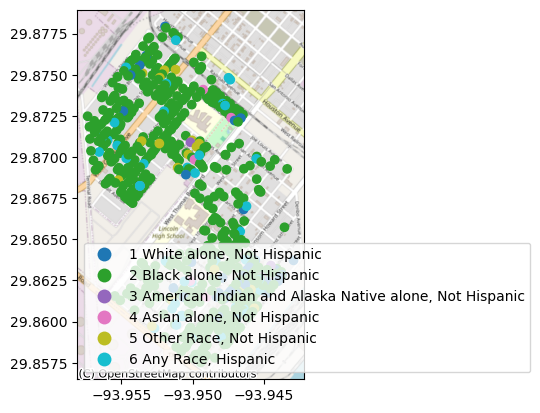

In [49]:
# select points for site ID 1
ax = site1_hua_gdf.plot(column='Race Ethnicity', 
        legend=True)

ctx.add_basemap(ax, crs=site1_hua_gdf.crs, 
        source=ctx.providers.OpenStreetMap.Mapnik)

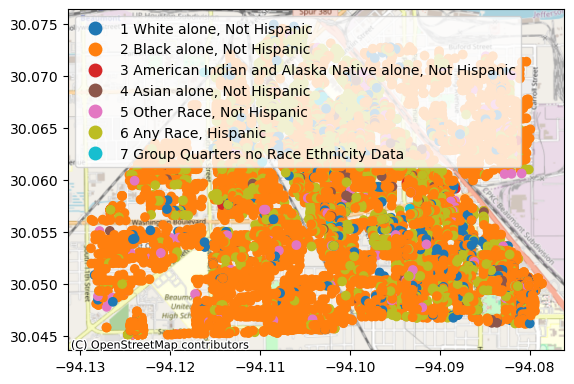

In [50]:
# select points for site ID 2
ax = site2_hua_gdf.plot(column='Race Ethnicity', 
        legend=True)

ctx.add_basemap(ax, crs=site2_hua_gdf.crs, 
        source=ctx.providers.OpenStreetMap.Mapnik)

# Output files

In [51]:
# Save Work at this point as CSV
savefile = programname+"_site1.csv"
site1_hua_gdf.to_csv(savefile, index=False)

In [52]:
# Save Work at this point as CSV
savefile = programname+"_site2.csv"
site2_hua_gdf.to_csv(savefile, index=False)

In [ ]:
# Alternative approach: Create conditions-based variable following the GitHub pattern
# This follows the pattern from ncoda_00d_cleanvarsutils.py

# Define conditions for low-income renter status
low_income_renter_conditions = {
    'cat_var': {
        'variable_label': 'Low Income Renter Status',
        'notes': 'Low Income Renter status based on below median income and renter occupancy'
    },
    'condition_list': {
        1: {
            'condition': "(df['ownershp'] == 2) & (df['randincome'] < df['randincome'].median()) & (df['randincome'].notna())",
            'value_label': "Low Income Renter"
        },
        2: {
            'condition': "(df['ownershp'] == 1) & (df['randincome'] < df['randincome'].median()) & (df['randincome'].notna())",
            'value_label': "Low Income Owner"
        },
        3: {
            'condition': "(df['ownershp'] == 2) & (df['randincome'] >= df['randincome'].median()) & (df['randincome'].notna())",
            'value_label': "Higher Income Renter"
        },
        4: {
            'condition': "(df['ownershp'] == 1) & (df['randincome'] >= df['randincome'].median()) & (df['randincome'].notna())",
            'value_label': "Higher Income Owner"
        }
    }
}

# Apply the conditions using the add_label_cat_conditions_df function from GitHub
hua_air_gdf_with_income_tenure = add_label_cat_conditions_df(
    hua_air_gdf_with_demographics.copy(), 
    conditions=low_income_renter_conditions
)

print("Income-Tenure Status distribution:")
print(hua_air_gdf_with_income_tenure['Low Income Renter Status_str'].value_counts(dropna=False))

# Create a simplified binary version for analysis
hua_air_gdf_with_income_tenure['Is_Low_Income_Renter'] = (
    hua_air_gdf_with_income_tenure['Low Income Renter Status_str'] == "Low Income Renter"
).astype(int)

# Replace 0 with np.nan for missing data cases
missing_mask = (
    hua_air_gdf_with_income_tenure['randincome'].isna() | 
    hua_air_gdf_with_income_tenure['ownershp'].isna()
)
hua_air_gdf_with_income_tenure.loc[missing_mask, 'Is_Low_Income_Renter'] = np.nan

print(f"\nBinary Low Income Renter indicator:")
print(f"Low Income Renters (1): {hua_air_gdf_with_income_tenure['Is_Low_Income_Renter'].sum():,.0f}")
print(f"Not Low Income Renters (0): {(hua_air_gdf_with_income_tenure['Is_Low_Income_Renter'] == 0).sum():,.0f}")
print(f"Missing data: {hua_air_gdf_with_income_tenure['Is_Low_Income_Renter'].isna().sum():,.0f}")

# Show median income threshold
median_income = hua_air_gdf_with_demographics['randincome'].median()
print(f"\nIncome threshold (median): ${median_income:,.0f}")

hua_air_gdf_with_income_tenure.head()